In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

import scipy
from scipy.interpolate import make_interp_spline, BSpline

import seaborn as sns

from cmdstanpy import CmdStanModel
import arviz as az

import json

from scipy import stats


# Age Model


## Age Model supplementary

We use notation:

\begin{align*}
[Co] &- \text{Co weight } \% \\
[Mn] &- \text{Mn weight } \% \\
[Fe] &- \text{Fe weight } \% \\
x &- \text{slice depth} \\
[Co\%] &- \text{norm Co weight }\% \\ 
GR &- \text{growth rate} \\
Age &- \text{age of the sample} 
\end{align*}

All data was scaled close to 1 before fitting for numerical stability.

It is assumed that normalized [Co%] follows linearly decreasing trend as a function of slice depth as was observed from Fig.$\sim$ S1A. As given by Yi (2022), age of the sample can be expressed as a function of [Co%], and thus further as function of sampling depth. 

\begin{align}
\text{[Co \%]} &= 50\frac{[Co]}{[Mn]+[Fe]} \\
\text{[Co \%]} &= \alpha e^{\beta x} \\
\text{GR} &= \frac{a}{\text{[Co \%]}^b} \\
\text{Age} &= \sum_{d_0}^{d} \text{GR}(\text{[Co \%]})\\ 
\text{Age} &= \int_{d_0}^{d} \frac{a}{[Co \%]^b} dx \\ 
\text{Age} &= \int_{d_0}^{d} \frac{a}{(\alpha e^{\beta x})^b} dx \\
\text{Start from the surface: } d_0 &= 0 \\
\text{Age} &= \frac{a}{b \alpha^b \beta}*(1-e^{-b \beta d}) ; \\
\end{align}

Sampling depths and measured material contents were considered as unknowns and computed based on the measured value and given error estimate. This allows the model to "move" the variables with limitations to better fit the values simultaneously. In the model, we use equations (1), (2), and (8) to fit unknown variables in respect to the calibration data sets and measured data.

### Low level priors

\begin{align*}
   d_{Co_{ \mu \mu}}, d_{ \text{Age}_{ \mu \mu }}, \text{Fe}_{\mu \mu}, \text{Mn}_{\mu \mu}, \text{Co}_{\mu \mu}, \text{[Co \%]}_{\sigma \mu}, Age_{\sigma \mu} & \sim \text{Normal}() \\
   d_{Co_{ \mu \sigma}}, d_{Age_{\mu \sigma}}, \text{Fe}_{\mu \sigma}, \text{Mn}_{\mu \sigma}, \text{Co}_{\mu \sigma}, \text{[Co \%]}_{\sigma \sigma}, {[Co \%]}_{\sigma \sigma}, Age_{\sigma \sigma}, Age_{\sigma \mu \sigma}, \text{[Co \%]}_{\text{n}, \sigma} & \sim \text{Inv gamma}() \\
   nu_\text{[Co \%]}, nu_\text{Co}, nu_\text{Age} & \sim \gamma(2,0.1) \\
\end{align*}

### Function priors

\begin{align*}
\alpha, \beta, a, b & \sim \text{Normal}()
\end{align*}

### Other 

\begin{align*}
\text{[Co \%]}_\sigma & \sim  \text{normal}(\text{[Co \%]}_{\sigma \mu}, \text{[Co \%]}_{\sigma \sigma}) \\
\text{Fe}_{\mu} & \sim \text{normal} (\text{Fe}_{\mu \mu}, \text{Fe}_{\mu \sigma}) \\
\text{Mn}_{\mu} & \sim \text{normal} (\text{Mn}_{\mu \mu}, \text{Mn}_{\mu \sigma}) \\
\text{Co}_{\mu} & \sim \text{normal} (\text{Co}_{\mu \mu}, \text{Co}_{\mu \sigma}) \\
\text{[Co \%]} & \sim  \text{student t}(nu_\text{Co}, f_\text{[Co \%],n}, \text{[Co \%]}_{\text{n}, \sigma}) \\
\text{[Co \%]} & \sim  \text{student t}(nu_\text{[Co \%]}, f_\text{[Co \%]}, \text{[Co \%]}_\sigma) \\
\end{align*}

### Likelyhood

\begin{align*}
\text{Fe} & \sim \text{normal} (\text{Fe}_{\mu}, \text{Fe}_{\sigma}) \\
\text{Mn} & \sim \text{normal} (\text{Mn}_{\mu}, \text{Mn}_{\sigma}) \\
\text{Co} & \sim \text{normal} (\text{Co}_{\mu}, \text{Co}_{\sigma}) \\
d_{\text{Co}_\mu} & \sim  \text{normal}( \text{normal}(d_{Co_{\mu \mu}}, d_{Co_{\mu \sigma}}), \sigma_\text{Co depth}) \\
d_{\text{Age}_\mu} & \sim  \text{normal}( \text{normal}(d_{Age_{\mu \mu}}, d_{Age_{\mu \sigma}}), \sigma_\text{Age depth}) \\
\text{Age}_\sigma & \sim  \text{normal}( \text{normal}(\text{Age}_{\sigma \mu}, \text{Age}_{\sigma \mu \sigma}), \text{Age}_{\sigma \sigma}) \\
\text{Age} & \sim  \text{student t}(nu_\text{Age}, f_\text{Age}, \text{Age}_{\sigma \mu}) \\
\end{align*}

### Functions

In above:
\begin{align*}
f_\text{[Co \%], n} &= 50 \frac{\text{Co}_{\mu} }{\text{Fe}_{\mu}  + \text{Mn}_{\mu} } \\
f_\text{[Co \%]} &= \alpha e^{\beta*d_{\text{Co}_\mu}} \\
f_\text{Age} &= \frac{a}{b*\alpha^b*\beta}(1-e^{-b*d_{\text{Age}_\mu}*\beta})  \\
\end{align*}

As Yi et al. (2022) addressed that interpredibility of a and b parameters are not absolute and growth rate can be expressed in various patterns. Therefore, weakly informative priors were assigned for a and b. However, $\alpha$ describes the normalized Co content of the sample at the surface and $\beta$ the rate of content decay. Therefore, informative priors were assigned to $\alpha$ and $\beta$ based on evaluation of the plotted figures. Similarly, relative informative priors were given for depths parameters and errors included in the model based on visual evaluation of the data points. We took the given error estimates as given from the previous publications and included them into the model. 

The model was validated by confirming that the Monte Carlo algorithm had explored the parameter space without divergence using stan diagnostics tools. Furhermore, the model estimations were visually compared with initial data and corfirmed reasonable. We further tested the model model stability by cross validation leaging data points out at a time. Subsequently, we estimated the performance using expected log pointwise predictive density (ELPD).

Model diagnostics indixate that MC computation was success full and computing time is low. Visual inspection and evaluation of distributions and computed trends indicates sufficient performance. Numberical diagnostics suggests that the model is not optimal fit for the given data points with given error estimates. There are two possible reasons either the model is poor for the observations or then error estimates of the variables are unreliable. We also did some alternative models 1) switching exponential decay to linear functions, and 2) computing without normalizing the Co content. However, no better performance was reached and also the implemented solution is the most reasonable in the context.

We conclude that the model performed relatively well on the data and the results are reliable enough for our applications.



### Reference

Carpenter B, Gelman A, Hoffman MD, Lee D, Goodrich B, Betancourt M, et al. Stan: A probabilistic programming language. Journal of statistical software. 2017;76(1). pmid:36568334

Lougheed, Bryan C., and S. P. Obrochta. "A rapid, deterministic age‐depth modeling routine for geological sequences with inherent depth uncertainty." Paleoceanography and Paleoclimatology 34.1 (2019): 122-133.

Jiang, X. D., et al. "Abyssal manganese nodule recording of global cooling and Tibetan Plateau uplift impacts on Asian aridification." Geophysical Research Letters 49.3 (2022): e2021GL096624.

In [81]:
def scaler(data):
    return (data - 0)/(data.max()-0)

def scaler_rev(data, norm):
    return (data+1e-3)*(norm.max()-0) + 0

def func_Co_n_error(Co, dCo, Fe,dFe,Mn,dMn):
    return 50/(Fe+Mn)*dCo + 50*Co/(Fe+Mn)**2*dFe + 50*Co/(Fe+Mn)**2*dMn

def func_Co_n(Co, Fe, Mn):
    return 50*Co/(Fe+Mn)

def func_e(x,alpha,beta,a,b, c,e):
    return c*a/(b*pow(alpha, b)*beta)*(1-np.exp(-b*x*beta)) +e

def func_exp(x, alpha, beta):
    return alpha*np.exp(beta*x)

In [82]:
root = "./tools/GR_results.xlsx" # change this to ~/Agemodeldatamgbc202141.xlsx
df_results = pd.read_excel(root)
df_results.columns = ["depth", "GR"]

In [83]:
root = "./tools/Agemodeldatamgbc202141.xlsx" # change this to ~/Agemodeldatamgbc202141.xlsx
df = pd.read_excel(root, skiprows = np.arange(0,3))

dataDict = {}

dataDict["Ages"] = np.concatenate([df["Pb-age"].values[:4],df["Age"].values[:2]], axis = 0)
dataDict["Ages_error"] = np.concatenate([df["2σ.5"].values[:4]/2,df["±.3"].values[:2]/2], axis = 0) 

dataDict["Ages_d"] = np.concatenate([df["depth (mm)"].values[:4],df["Depth (mm)"].values[:2]], axis = 0)*1e-3
dataDict["Ages_d_error"] = np.concatenate([df["±.1"].values[:4], df["±.2"].values[:2]], axis = 0)*1e-3*0.5

dataDict["Co_d"] = df["Sampling depth (mm)"].values*1e-3
dataDict["Co_d_error"] = (df["±"].values*1e-3)/2

dataDict["Co"] = 50*df["Co (wt-%)"].values/(df["Fe (wt-%)"].values + df["Mn (wt-%)"].values)

dataDict["Co_"] = df["Co (wt-%)"].values
dataDict["Co_sigma"] = df['2σ.2'].values/2

dataDict["Fe_"] = df["Fe (wt-%)"].values 
dataDict["Fe_sigma"] = df['2σ'].values/2

dataDict["Mn_"] = df["Mn (wt-%)"].values
dataDict["Mn_sigma"] = df['2σ.1'].values/2

dataDict["Co_error"] = func_Co_n_error(dataDict["Co_"] ,dataDict["Co_sigma"] ,dataDict["Fe_"] ,dataDict["Fe_sigma"],dataDict["Mn_"] ,dataDict["Mn_sigma"] )


In [84]:

datas = {}


datas["Ages"] = (dataDict["Ages"]*1e-4).tolist()
datas["Ages_error"] = np.abs(dataDict["Ages_error"]*1e-4).tolist()

datas["Co_"] = (dataDict["Co_"]).tolist() 
datas["Co_e"] =  np.abs((dataDict["Co_sigma"])).tolist()

datas["Fe_"] = (dataDict["Fe_"]).tolist() 
datas["Fe_e"] =  np.abs((dataDict["Fe_sigma"])).tolist()

datas["Mn_"] = (dataDict["Mn_"]).tolist() 
datas["Mn_e"] =  np.abs((dataDict["Mn_sigma"])).tolist()


datas["Co_d"] = (dataDict["Co_d"]*100).tolist()
datas["Co_d_error"] = np.abs(dataDict["Co_d_error"]*100).tolist()

datas["Ages_d"] = (dataDict["Ages_d"]*100).tolist()
datas["Ages_d_error"] = np.abs(dataDict["Ages_d_error"]*100).tolist()

datas["n_i"] = len(dataDict["Co"])
datas["n_j"] = len(dataDict["Ages"])

datas['n_Co_n_indices'] = (np.arange(datas['n_i'])+1).tolist()
datas['n_Co_indices'] = (np.arange(datas['n_i'])+datas['n_i']+1).tolist()
datas['n_j_indices'] = (np.arange(datas['n_j'])+int(2*datas['n_i'])+1).tolist()

with open('data_.json','w') as f:
    json.dump(datas,f)



Exp fit
 0.03890710289721647 -0.5534601112128824
Fit func_(x,alpha,beta,a,b,e): 
 1.3339145381776867 -1.0664090291484438 0.9956312575769798 0.48912435080630845 0.7571294112923507 -0.15764758952443028


C:\Users\Arttu\AppData\Local\Temp\ipykernel_2616\946304464.py:14: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func_e, datas["Ages_d"], datas["Ages"], bounds=bounds, maxfev = 1000000)


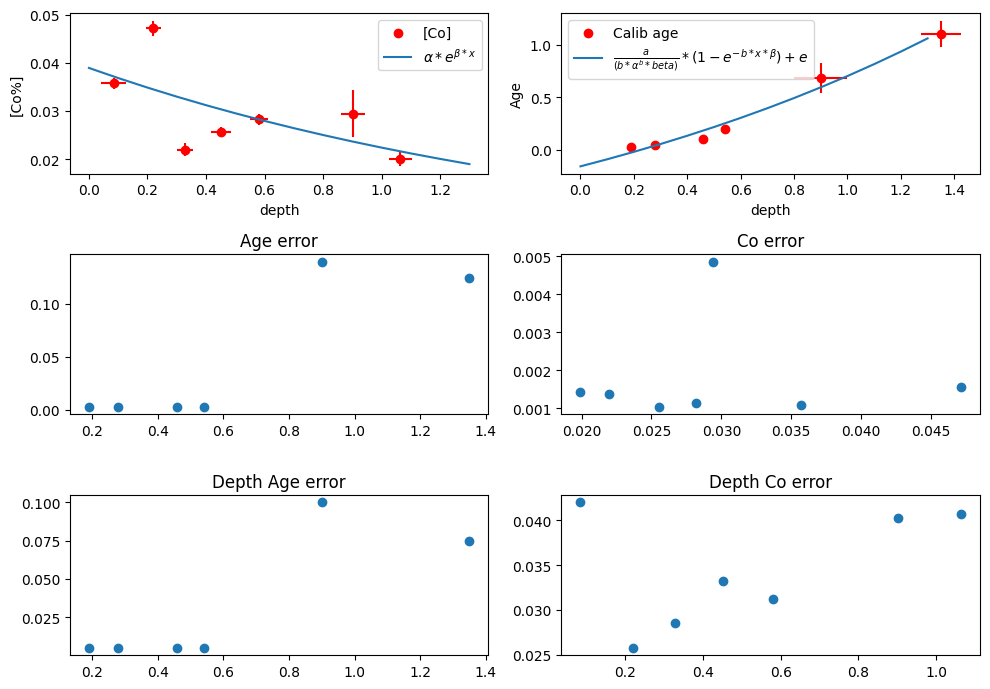

In [85]:
Co_ = func_Co_n(dataDict["Co_"], dataDict["Fe_"], dataDict["Mn_"])

Co_error = func_Co_n_error(dataDict["Co_"] ,dataDict["Co_sigma"] ,dataDict["Fe_"] ,dataDict["Fe_sigma"],dataDict["Mn_"] ,dataDict["Mn_sigma"] )

xdata_Co = np.arange(0,np.concatenate((datas["Ages_d"], datas["Co_d"])).max(), 0.1)
popt, pcov = curve_fit(func_exp, datas["Co_d"], Co_)
ydata_Co = func_exp(xdata_Co, *popt)

print("Exp fit\n", *popt)

bounds = ([-np.inf, -np.inf, -np.inf, -np.inf, -np.inf,-np.inf], [np.inf, 0, np.inf, np.inf, np.inf, np.inf])
guess = np.array([0.1, -2, 1e-3, 0.1, 0.1, 0.1])

popt, pcov = curve_fit(func_e, datas["Ages_d"], datas["Ages"], bounds=bounds, maxfev = 1000000)
ydata_Ages = func_e(xdata_Co, *popt)

print("Fit func_(x,alpha,beta,a,b,e): \n", *popt)


fig, ax = plt.subplots(3,2,figsize=(10,7))

ax[0,0].errorbar(datas["Co_d"], Co_, xerr = datas["Co_d_error"],yerr=Co_error, fmt=' ',color = "red")
ax[0,0].scatter(datas["Co_d"], Co_, color = "red", label = "[Co]")

ax[0,0].plot(xdata_Co, ydata_Co, label = r"$\alpha*e^{\beta*x}$")
#ax[0,0].set_ylim(0,0.1)
#ax[0].set_ylim(0,1)

ax[0,0].set_ylabel("[Co%]")
ax[0,0].set_xlabel("depth")
ax[0,0].legend()

ax[0,1].errorbar(datas["Ages_d"], datas["Ages"], xerr = datas["Ages_d_error"], yerr=datas["Ages_error"], fmt=' ',color = "red")
ax[0,1].scatter(datas["Ages_d"], datas["Ages"],color = "red", label = "Calib age")
ax[0,1].plot(xdata_Co, ydata_Ages, label = r"$\frac{a}{(b*\alpha^b*beta)}*(1-e^{-b*x*\beta}) + e$")
#ax[1].set_xscale("log")
#ax[1].set_yscale("log")

ax[0,1].set_ylabel("Age")
ax[0,1].set_xlabel("depth")
ax[0,1].legend()


ax[1,0].set_title("Age error")
ax[1,0].scatter(datas["Ages_d"],datas["Ages_error"], label = "calib age")
ax[1,1].set_title("Co error")
ax[1,1].scatter(Co_, Co_error,  label = "[Co]")

ax[2,0].set_title("Depth Age error")
ax[2,0].scatter(datas["Ages_d"],datas["Ages_d_error"], label = "calib age")
ax[2,1].set_title("Depth Co error")
ax[2,1].scatter(datas["Co_d"], datas["Co_d_error"],  label = "[Co]")

fig.tight_layout()

In [7]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import matplotlib.pyplot as plt
from IPython.display import display, clear_output

%matplotlib tk

%matplotlib tk

fig, ax = plt.subplots(1,2, constrained_layout=True, figsize=(8, 5))

def plot_func(alpha,beta,a,b): #c, e
    
    ax[1].scatter(datas["Ages_d"], datas["Ages"])
    ax[1].errorbar(datas["Ages_d"], datas["Ages"], xerr = datas["Ages_d_error"],yerr=datas["Ages_error"], fmt=' ',color = "red")

    x = np.linspace(0, 1.5, 100)
    yy = a/(b*pow(alpha, b)*beta)*(1-np.exp(-b*x*beta)) # c e

    ax[1].plot(x, yy)
    ax[1].set_ylim((0,2))

    y = alpha*(np.exp(beta*x))

    ax[0].plot(x, y)
    ax[0].scatter(datas["Co_d"], 10*(50*np.array(datas["Co_"]))/(np.array(datas["Fe_"])+np.array(datas["Mn_"])))
    #ax[0].errorbar(datas["Co_d"], datas["Co"], xerr = datas["Co_d_error"], yerr=datas["Co_error"], fmt=' ',color = "red")



alpha_init = 0.6
beta_init= -1.4
a_init = 0.15
b_init = 1.2

ax[1].set_ylim((0,2))

interact(plot_func, alpha = widgets.FloatSlider(value=alpha_init,
                                               min=0,
                                               max=1,
                                               step=0.01), 
                    beta = widgets.FloatSlider(value=beta_init,
                                               min=-5,
                                               max=0,                                    
                                               step=0.01),
                    a = widgets.FloatSlider(value=a_init,
                                               min=-2,
                                               max=2,
                                               step=0.01), 
                    b = widgets.FloatSlider(value=b_init,
                                               min=-2,
                                               max=2,
                                               step=0.01)
                                               )

"""
,
                    c = widgets.FloatSlider(value=c_init,
                                               min=-2,
                                               max=2,
                                               step=0.01), 
                    e = widgets.FloatSlider(value=e_init,
                                               min=-2,
                                               max=2,
                                               step=0.01)
"""


interactive(children=(FloatSlider(value=0.6, description='alpha', max=1.0, step=0.01), FloatSlider(value=-1.4,…

'\n,\n                    c = widgets.FloatSlider(value=c_init,\n                                               min=-2,\n                                               max=2,\n                                               step=0.01), \n                    e = widgets.FloatSlider(value=e_init,\n                                               min=-2,\n                                               max=2,\n                                               step=0.01)\n'

In [86]:
model = CmdStanModel(stan_file='C:/Users/Arttu/Desktop/Codes/TeachingSolution/AgeModel/minSol_mod_exp.stan')
fit = model.sample(data='C:/Users/Arttu/Desktop/Codes/TeachingSolution/AgeModel/data_.json', adapt_delta=0.9999,max_treedepth=20)  #, adapt_delta=0.9999,max_treedepth=20 show_console=True) #, 

print(fit.diagnose())
fit.summary()

06:48:22 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

06:52:21 - cmdstanpy - INFO - CmdStan done processing.
06:52:21 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Location parameter[5] is inf, but must be finite! (in 'minSol_mod_exp.stan', line 114, column 3 to column 30)
	Exception: normal_lpdf: Location parameter[5] is inf, but must be finite! (in 'minSol_mod_exp.stan', line 114, column 3 to column 30)
	Exception: student_t_lpdf: Location parameter[4] is inf, but must be finite! (in 'minSol_mod_exp.stan', line 148, column 3 to column 52)
	Exception: student_t_lpdf: Location parameter[4] is inf, but must be finite! (in 'minSol_mod_exp.stan', line 148, column 3 to column 52)
	Exception: normal_lpdf: Location parameter[1] is inf, but must be finite! (in 'minSol_mod_exp.stan', line 113, column 3 to column 30)
	Exception: normal_lpdf: Location parameter[5] is inf, but must be finite! (in 'minSol_mod_exp.stan', line 114, column 3 to column 30)
Exception: normal_lpdf: Location parameter[3] is inf, but must b


Processing csv files: C:\Users\Arttu\AppData\Local\Temp\tmptip7cwip\minSol_mod_expaqhdq2m7\minSol_mod_exp-20250128064822_1.csv, C:\Users\Arttu\AppData\Local\Temp\tmptip7cwip\minSol_mod_expaqhdq2m7\minSol_mod_exp-20250128064822_2.csv, C:\Users\Arttu\AppData\Local\Temp\tmptip7cwip\minSol_mod_expaqhdq2m7\minSol_mod_exp-20250128064822_3.csv, C:\Users\Arttu\AppData\Local\Temp\tmptip7cwip\minSol_mod_expaqhdq2m7\minSol_mod_exp-20250128064822_4.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete, no problems detected.



,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
lp__,-13.964500,0.169578,6.749710,-25.539400,-13.662100,-3.243140,1584.280,5.78453,1.00275
alpha,0.638595,0.004710,0.208697,0.312152,0.627102,1.002140,1963.000,7.16729,1.00087
beta,-2.032630,0.008475,0.447933,-2.771490,-2.028800,-1.308180,2793.780,10.20060,1.00002
a,0.154187,0.004423,0.112886,0.040664,0.126415,0.363088,651.271,2.37792,1.00763
b,0.921209,0.013440,0.383631,0.322926,0.913481,1.545540,814.791,2.97496,1.00890
...,...,...,...,...,...,...,...,...,...
y_hat[16],0.074138,0.001836,0.118369,-0.074844,0.062883,0.248749,4154.450,15.16870,1.00018
y_hat[17],0.146410,0.002471,0.133900,-0.041197,0.130960,0.367455,2936.410,10.72140,1.00035
y_hat[18],0.187462,0.002425,0.137649,-0.013363,0.191981,0.403893,3220.830,11.75990,1.00046
y_hat[19],0.524125,0.004413,0.252803,0.098814,0.545560,0.877981,3281.270,11.98050,1.00018


c:\Users\Arttu\Anaconda3\envs\stan\Lib\site-packages\arviz\plots\traceplot.py:223: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (35), generating only 20 plots
  warnings.warn(


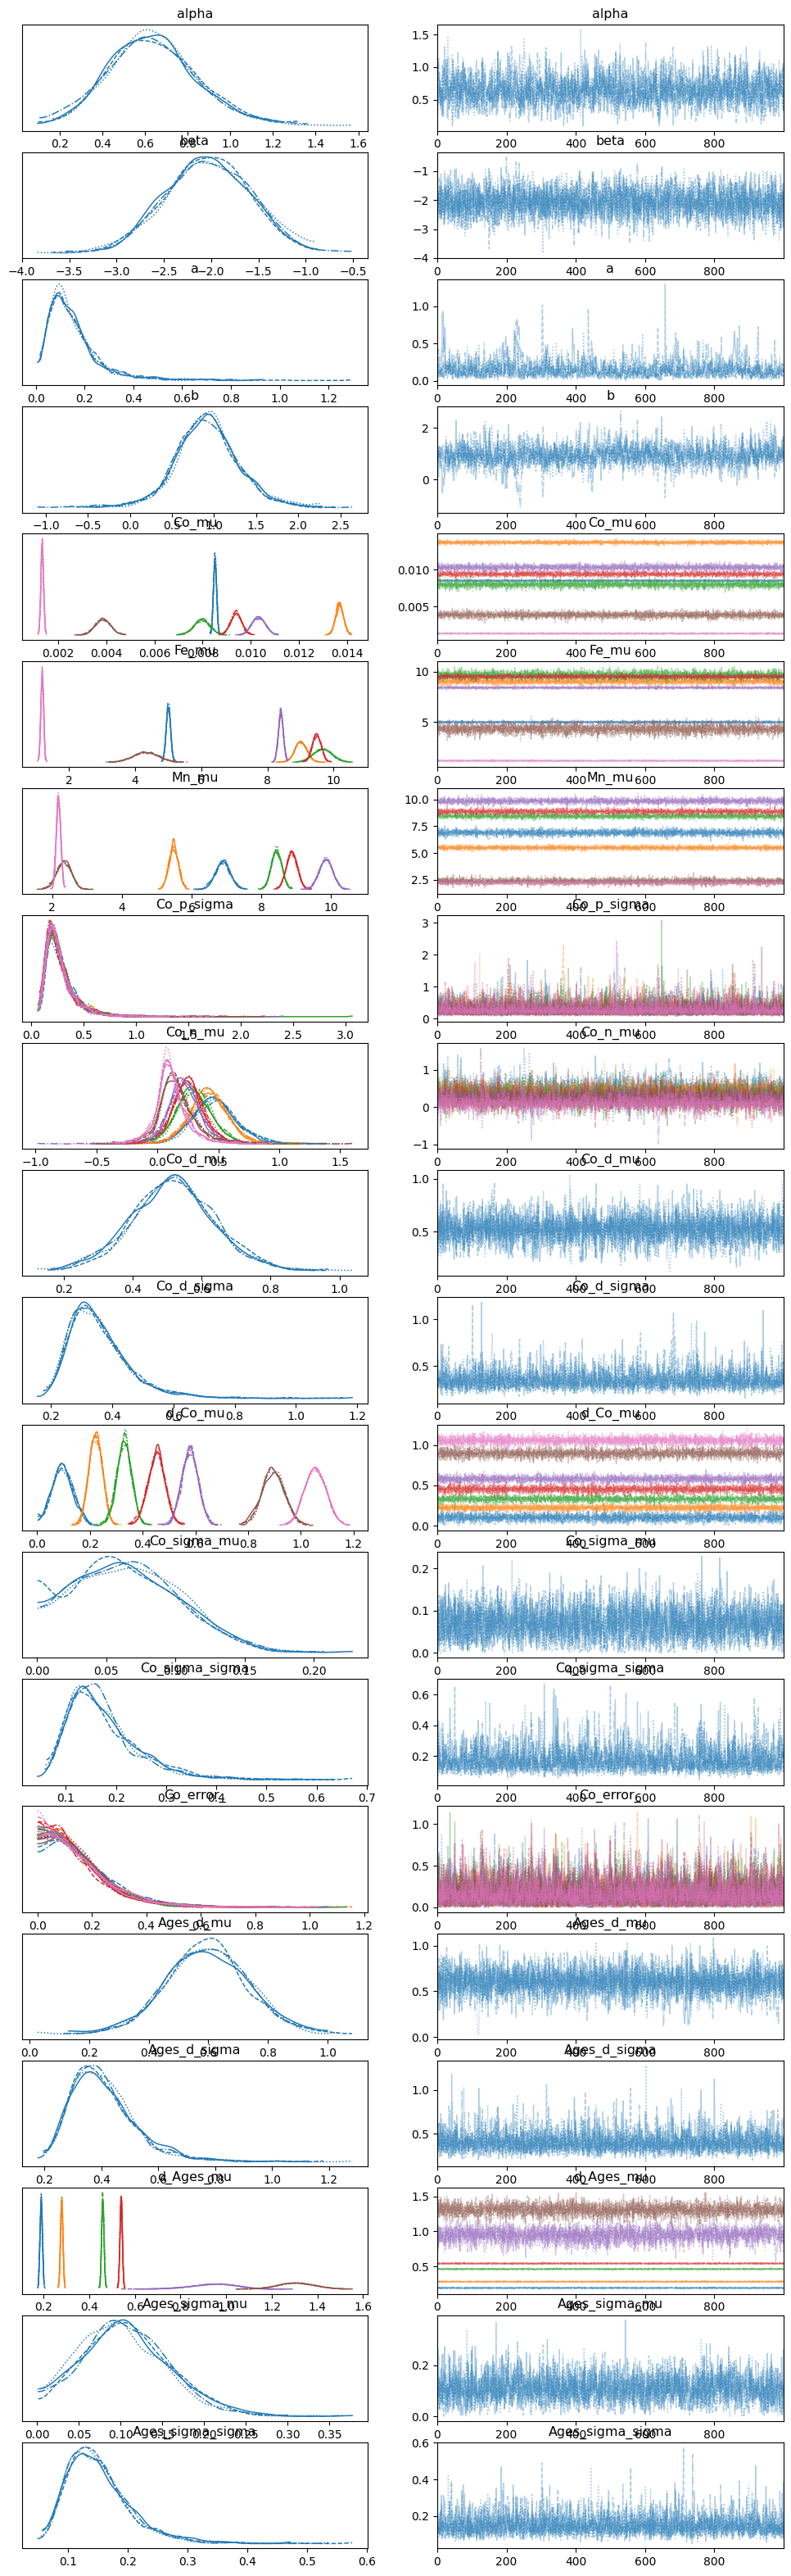

In [87]:
%matplotlib inline

azOut = az.from_cmdstanpy(posterior=fit)


#_ = az.plot_posterior(azOut)
_ = az.plot_trace(azOut)



Computed from 4000 posterior samples and 27 observations log-likelihood matrix.

         Estimate       SE
elpd_loo    49.75    15.54
p_loo       26.19        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.70]   (good)        5   18.5%
   (0.70, 1]   (bad)        18   66.7%
   (1, Inf)   (very bad)    4   14.8%



c:\Users\Arttu\Anaconda3\envs\stan\Lib\site-packages\arviz\stats\stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


<Axes: xlabel='Data Point', ylabel='Shape parameter k'>

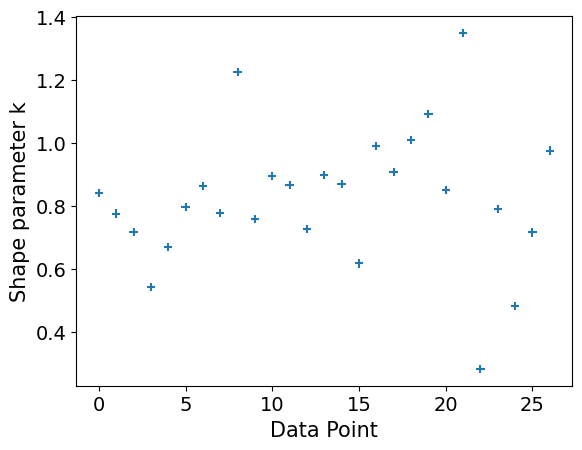

In [88]:
loo = az.loo(azOut,pointwise=True)
print(loo)

az.plot_khat(loo)

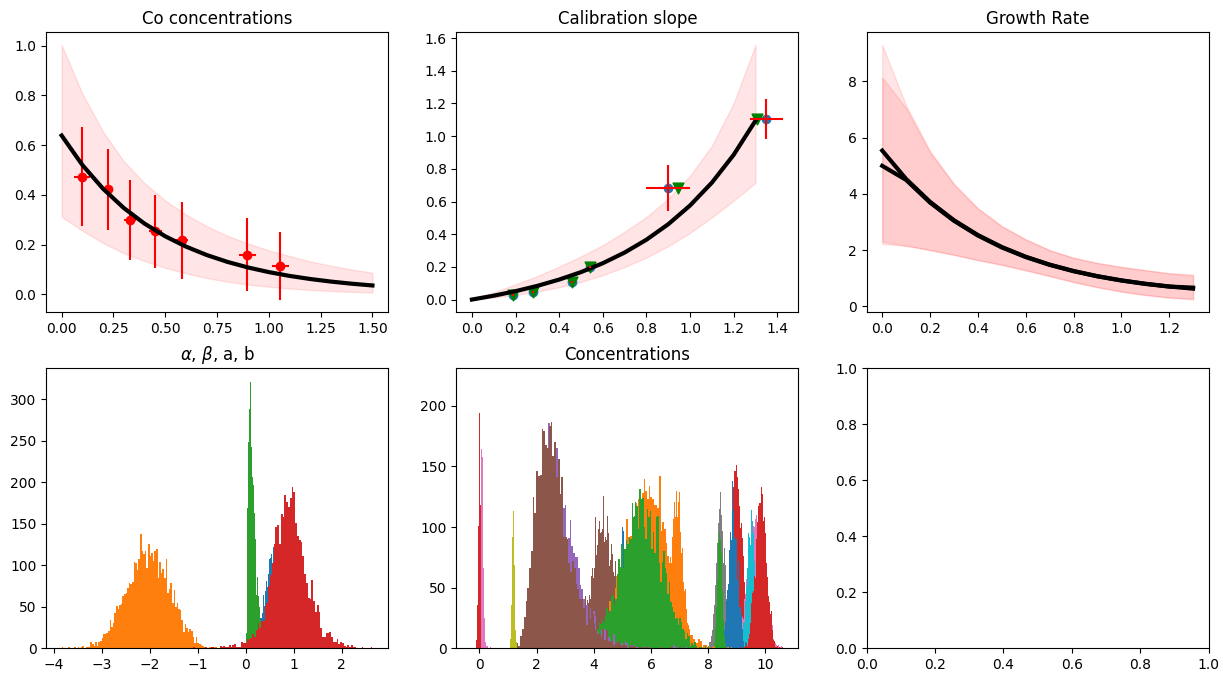

In [89]:
draws = fit.draws_pd()
draws.keys()

alpha = draws['alpha'].values[...,None]
beta = draws['beta'].values[...,None]

a = draws['a'].values[...,None]
b = draws['b'].values[...,None]

Co_mu = np.array(draws.filter(regex='^Co_mu'))
Fe_mu = np.array(draws.filter(regex='^Fe_mu'))
Mn_mu = np.array(draws.filter(regex='^Mn_mu'))

Co = np.array(draws.filter(regex='^Co_n_mu'))
Co_d = np.array(draws.filter(regex='^d_Co_mu'))

fig, ax = plt.subplots(2,3,figsize=(15,8))

ax[1,0].set_title(r"$\alpha$, $\beta$, a, b")
_ = ax[1,0].hist(alpha, bins = 100)
_ = ax[1,0].hist(beta, bins = 100)
_ = ax[1,0].hist(a, bins = 100)
_ = ax[1,0].hist(b, bins = 100)

# Co concentration

xx = np.mean(Co_d, axis = 0)
means = np.mean(Co, axis = 0)

xx_error = np.std(Co_d, axis = 0)
means_error = np.std(Co, axis = 0)

ax[0,0].scatter(xx,means,color = "red", label='mean')
ax[0,0].errorbar(xx,means, xerr = xx_error,yerr= means_error, fmt=' ',color = "red")

xx = np.arange(0, np.max(datas["Co_d"])+0.5,1e-1)
yy = np.exp(beta*xx)*alpha

means = np.mean(yy, axis = 0)
p95s = np.percentile(yy, 95, axis = 0)
p5s = np.percentile(yy, 5, axis = 0)

ax[0,0].plot(xx,means,"black",linewidth=3,label='mean')
ax[0,0].fill_between(xx,p5s,p95s, color = "red", alpha= 0.1)
ax[0,0].set_title("Co concentrations")

# Age
xx = np.arange(0, np.max(datas["Ages_d"]),1e-1)
yy = a/(b*pow(alpha,b)*beta)*(1-np.exp(-b*xx*beta)) 

means = np.mean(yy, axis = 0)
p95s = np.percentile(yy, 95, axis = 0)
p5s = np.percentile(yy, 5, axis = 0)

ax[0,1].plot(xx,means,"black",linewidth=3,label='mean')
ax[0,1].fill_between(xx,p5s,p95s, color = "red", alpha= 0.1)
ax[0,1].scatter(datas["Ages_d"], datas["Ages"])
ax[0,1].errorbar(datas["Ages_d"], datas["Ages"], xerr = datas["Ages_d_error"],yerr=datas["Ages_error"], fmt=' ',color = "red")
ax[0,1].scatter(draws.filter(regex='d_Ages_mu').mean(axis=0).values, datas["Ages"],color = "green",marker='v',s=60)
ax[0,1].set_title("Calibration slope")

yy_year = yy

#GR
xx = np.arange(0, np.max(datas["Ages_d"]),1e-1) #np.max(datas["Co_d"])
yy = 1/(a/(alpha*np.exp(beta*xx))**b)

means = np.mean(yy, axis = 0)
p95s = np.percentile(yy, 95, axis = 0)
p5s = np.percentile(yy, 5, axis = 0)

ax[0,2].plot(xx,means,"black",linewidth=3,label='mean - analytical')
ax[0,2].fill_between(xx,p5s,p95s, color = "red", alpha= 0.1)

GR_yy = np.gradient(xx, axis = 0)/np.gradient(yy_year, axis = 1) #m/years -> mm/years

means = np.mean(GR_yy, axis = 0)
p95s = np.percentile(GR_yy, 95, axis = 0)
p5s = np.percentile(GR_yy, 5, axis = 0)

ax[0,2].plot(xx,means,"black",linewidth=3,label='mean - numeric')
ax[0,2].fill_between(xx,p5s,p95s, color = "red", alpha= 0.1)
ax[0,2].set_title("Growth Rate")

ax[1,1].set_title(r"Concentrations")

for i in range(Fe_mu.shape[1]):
    _ = ax[1,1].hist(Fe_mu[:,i], bins = 100)
    _ = ax[1,1].hist(Mn_mu[:,i], bins = 100)
    _ = ax[1,1].hist(Co_mu[:,i], bins = 100)

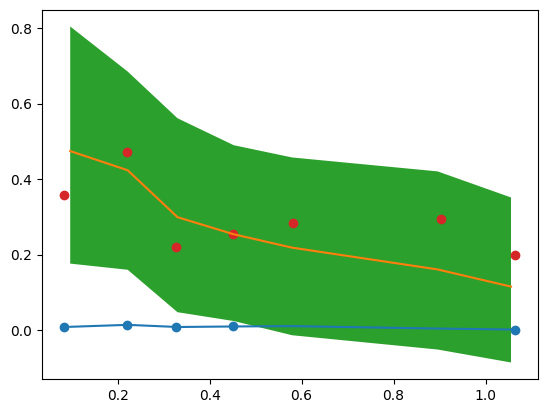

In [90]:
d_Co = np.array(draws.filter(regex='^d_Co_mu'))
d_Co_mean = np.mean(d_Co, axis = 0)

p95s = np.percentile(Co_mu, 95, axis = 0)[:7]
p5s = np.percentile(Co_mu, 5, axis = 0)[:7]
Co_mu_mean = np.mean(Co_mu, axis = 0)[:7]

plt.plot(d_Co_mean, Co_mu_mean)
plt.scatter(datas["Co_d"], datas["Co_"])
plt.fill_between(d_Co_mean,p5s, p95s)

p95s = np.percentile(Fe_mu, 95, axis = 0)[:7]
p5s = np.percentile(Fe_mu, 5, axis = 0)[:7]
Fe_mu_mean = np.mean(Fe_mu, axis = 0)[:7]

# plt.plot(d_Co_mean, Fe_mu_mean)
# plt.scatter(datas["Co_d"], datas["Fe_"])
# plt.fill_between(d_Co_mean,p5s, p95s)

p95s = np.percentile(Mn_mu, 95, axis = 0)[:7]
p5s = np.percentile(Mn_mu, 5, axis = 0)[:7]
Mn_mu_mean = np.mean(Mn_mu, axis = 0)[:7]

# plt.plot(d_Co_mean, Mn_mu_mean)
# plt.scatter(datas["Co_d"], datas["Mn_"])
# plt.fill_between(d_Co_mean,p5s, p95s)

Co_n = np.array(draws.filter(regex='^Co_n_mu'))
p95s = np.percentile(Co_n, 95, axis = 0)
p5s = np.percentile(Co_n, 5, axis = 0)
Co_n_mean = np.mean(Co_n, axis = 0)

plt.plot(d_Co_mean, Co_n_mean)
#plt.scatter(datas["Co_d"], datas["Mn_"])
plt.fill_between(d_Co_mean,p5s, p95s)

plt.scatter(1e2*dataDict["Co_d"], 10*dataDict["Co"])


<>:52: SyntaxWarning: invalid escape sequence '\s'
<>:52: SyntaxWarning: invalid escape sequence '\s'
C:\Users\Arttu\AppData\Local\Temp\ipykernel_2616\1953471098.py:52: SyntaxWarning: invalid escape sequence '\s'
  ax[2].plot(means_+stds_, xx_scaled,'--b',alpha=0.8,label='$\sigma$')


0.06621999105899999


C:\Users\Arttu\AppData\Local\Temp\ipykernel_2616\1953471098.py:57: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax[2].errorbar(dataDict["Ages"][:n_db], dataDict["Ages_d"][:n_db]*1e3, yerr = dataDict["Ages_d_error"][:n_db]*1e3, xerr=dataDict["Ages_error"][:n_db], ecolor = "red",marker='s', mfc='red', mec='red',fmt='o',label='Be')
C:\Users\Arttu\AppData\Local\Temp\ipykernel_2616\1953471098.py:58: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax[2].errorbar(dataDict["Ages"][n_db:], dataDict["Ages_d"][n_db:]*1e3, yerr = dataDict["Ages_d_error"][n_db:]*1e3, xerr=dataDict["Ages_error"][n_db:], ecolor = "grey", marker='o', mfc='grey', mec='grey',fmt='o',label='C')


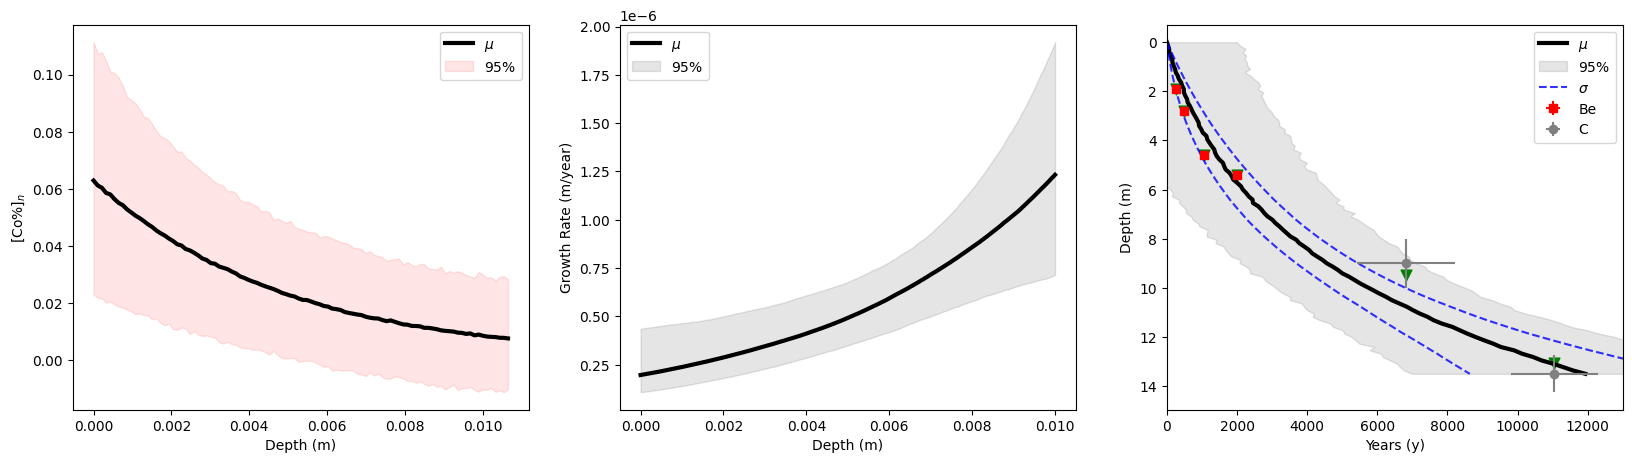

In [102]:
from scipy.stats import t

n_db = len(dataDict["Ages"][:4])

fig, ax = plt.subplots(1,3,figsize=(20,5))

# xx = np.arange(0, np.max(datas["Co_d"]),5e-1)
xx = np.linspace(0, np.max(datas["Co_d"]),100)
xx_scaled = np.linspace(0, np.max(dataDict["Co_d"]), len(xx))
yy_ = alpha*np.exp(beta*xx)

print(draws['Co_sigma_mu'].mean())
yy = t.rvs(np.array(draws['nu2'])[...,None],yy_,np.array(draws['Co_sigma_mu'])[...,None])*1e-1

means = np.median(yy, axis = 0)
stds = np.std(yy, axis = 0)
p95s = np.percentile(yy, 97.5, axis = 0)
p5s = np.percentile(yy, 2.5, axis = 0)

ax[0].plot(xx_scaled,means,"black",linewidth=3,label=r'$\mu$')
ax[0].fill_between(xx_scaled,p5s,p95s, color = "red", alpha= 0.1, label = r'$95\%$')

xx = df_results["depth"].values*1e-1
xx_scaled = df_results["depth"].values*1e-3
yy = (a/(alpha*np.exp(beta*xx))**b)*1e-6

means = np.median(yy, axis = 0)
stds = np.std(yy, axis = 0)
p95s = np.percentile(yy, 95, axis = 0)
p5s = np.percentile(yy, 5, axis = 0)

ax[1].plot(xx_scaled,means,"black",linewidth=3,label=r'$\mu$')
ax[1].fill_between(xx_scaled,p5s,p95s, color = "black", alpha= 0.1, label=r'$95\%$' )

# xx = np.arange(0, np.max(datas["Ages_d"]),1e-1)
xx = np.linspace(0, np.max(datas["Ages_d"]),100)
xx_scaled = np.linspace(0, np.max(dataDict["Ages_d"]), len(xx))*1e3
yy_ = (a/(b*pow(alpha,b)*beta)*(1-np.exp(-b*xx*beta)))
yy = t.rvs(np.array(draws['nu'])[...,None],yy_,np.array(draws['Ages_sigma_mu'])[...,None])*1e4

means = np.median(yy, axis = 0)
stds = np.std(yy, axis = 0)
p95s = np.percentile(yy, 95, axis = 0)
p5s = np.percentile(yy, 5, axis = 0)

means_ = np.median(yy_, axis = 0)*1e4
stds_ = np.std(yy_, axis = 0)*1e4


ax[2].plot(means, xx_scaled,"black",linewidth=3,label=r'$\mu$')
ax[2].fill_betweenx(xx_scaled,p5s, p95s , color = "black", alpha= 0.1,label=r'$95\%$')
ax[2].plot(means_+stds_, xx_scaled,'--b',alpha=0.8,label='$\sigma$')
ax[2].plot(means_-stds_, xx_scaled,'--b',alpha=0.8)

#ax[2].scatter(dataDict["Ages"][:n_db], dataDict["Ages_d"][:n_db], color = "black", label = "Data")
#ax[2].scatter(dataDict["Ages"][n_db:], dataDict["Ages_d"][n_db:], color = "black", label = "Data")
ax[2].errorbar(dataDict["Ages"][:n_db], dataDict["Ages_d"][:n_db]*1e3, yerr = dataDict["Ages_d_error"][:n_db]*1e3, xerr=dataDict["Ages_error"][:n_db], ecolor = "red",marker='s', mfc='red', mec='red',fmt='o',label='Be')
ax[2].errorbar(dataDict["Ages"][n_db:], dataDict["Ages_d"][n_db:]*1e3, yerr = dataDict["Ages_d_error"][n_db:]*1e3, xerr=dataDict["Ages_error"][n_db:], ecolor = "grey", marker='o', mfc='grey', mec='grey',fmt='o',label='C')
ax[2].scatter(dataDict["Ages"],draws.filter(regex='d_Ages_mu').mean(axis=0).values*1e1,marker='v',color='green',s=60)

ax[2].invert_yaxis()
ax[2].set_xlim(0,13000)
ax[0].set_xlabel(r"Depth (m)")
ax[0].set_ylabel(r"[Co$\%$]$_n$")
ax[0].legend()

ax[1].set_ylabel(r"Growth Rate (m/year)")
ax[1].set_xlabel(r"Depth (m)")
ax[1].legend()

ax[2].set_ylabel(r"Depth (m)")
ax[2].set_xlabel(r"Years (y)")
ax[2].legend()

In [103]:
xx = np.arange(0, np.max(datas["Ages_d"]),1e-3)
xx_scaled = np.linspace(0, np.max(dataDict["Ages_d"]), len(xx))*1e3
yy_ = alpha*np.exp(beta*xx)

yy = t.rvs(np.array(draws['nu2'])[...,None],yy_,np.array(draws['Ages_sigma_mu'])[...,None])*1e-1

x_val  = []
y_val  = []

for x_probe in datas["Co_d"]:
    idx = np.argmin(np.abs(x_probe-xx))

    x_val.append(xx_scaled[idx])
    y_val.append(yy[:,idx])
    

x_val = np.array(x_val)
y_val = np.array(y_val)

C:\Users\Arttu\AppData\Local\Temp\ipykernel_2616\1640355165.py:30: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.errorbar(d_Co_mean, Co_n_mean, xerr = 2*d_Co_std, yerr=2*Co_n_std, alpha = 0.4,ecolor = "blue", marker='o', mfc='blue', mec='blue',fmt='o',label=r'[Co$\%$]$_n$')


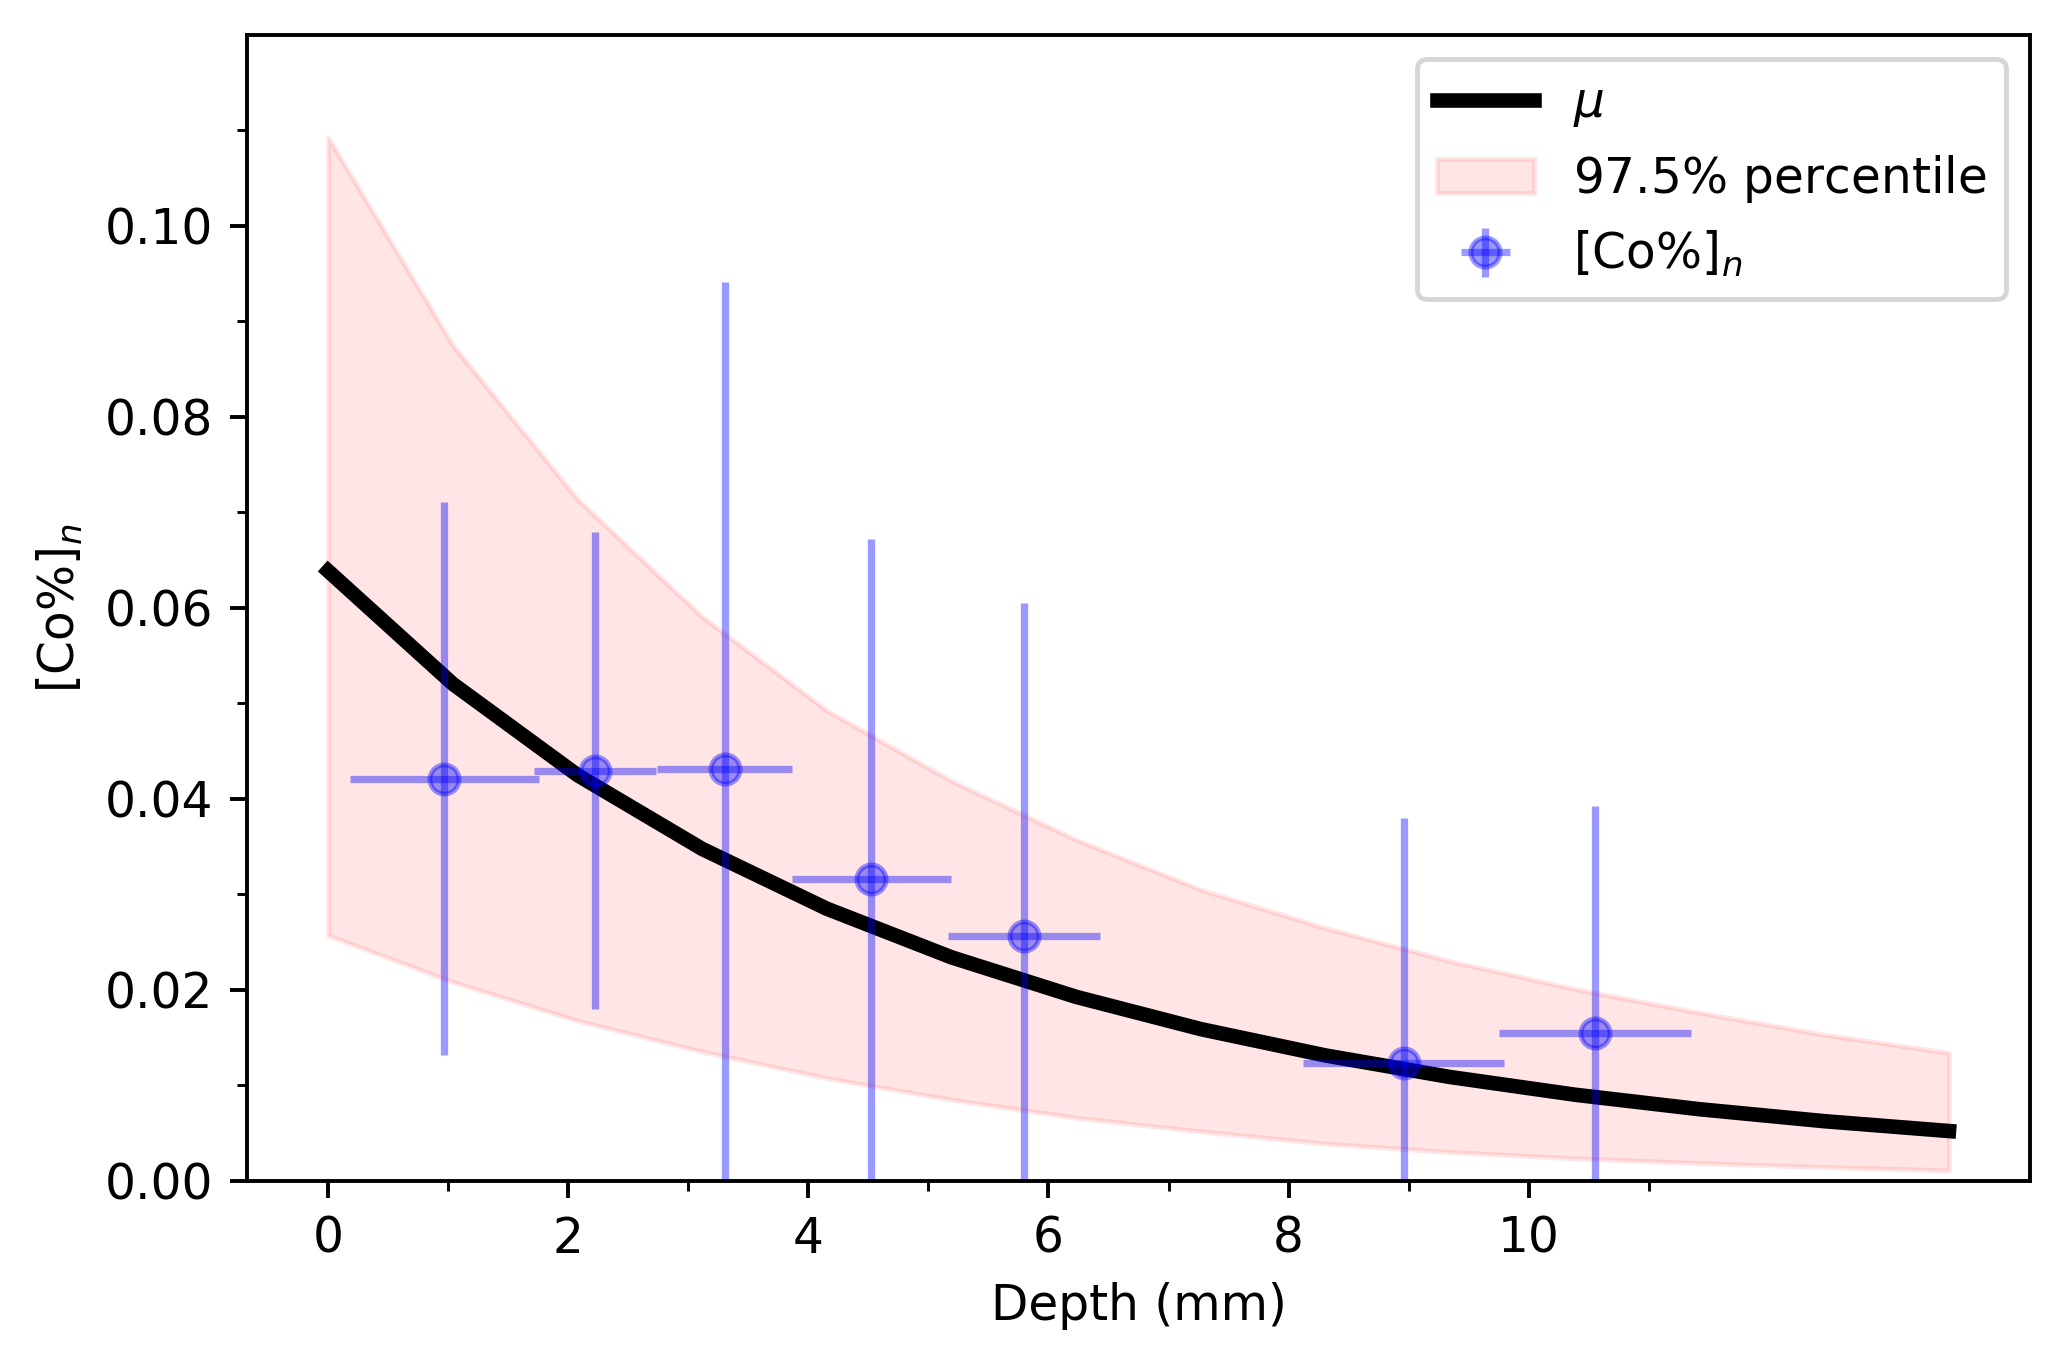

In [116]:
n_db = len(dataDict["Ages"][:4])

fig, ax = plt.subplots(1,1,figsize=(6,4), dpi= 350)

xx = np.arange(0, np.max(datas["Ages_d"]),1e-1)
xx_scaled = np.linspace(0, np.max(dataDict["Ages_d"]), len(xx))*1e3
yy = alpha*np.exp(beta*xx)*1e-1

means = np.mean(yy, axis = 0)
stds = np.std(yy, axis = 0)
p95s = np.percentile(yy, 97.5, axis = 0)
p5s = np.percentile(yy, 2.5, axis = 0)

ax.plot(xx_scaled,means,"black",linewidth=3,label=r'$\mu$')
ax.fill_between(xx_scaled, p5s, p95s, color = "red", alpha= 0.1, label = r'$97.5\%$ percentile')

Co_n = np.array(draws.filter(regex='^Co_n_mu'))[:7]*1e-1
p95s = np.percentile(Co_n, 95, axis = 0)
p5s = np.percentile(Co_n, 5, axis = 0)
Co_n_mean = np.mean(Co_n, axis = 0)
Co_n_std = np.std(Co_n, axis = 0)

d_Co = np.array(draws.filter(regex='^d_Co_mu'))*1e1
d_Co_mean = np.mean(d_Co, axis = 0)
d_Co_std = np.std(d_Co, axis = 0)

# ax.plot(d_Co_mean, Co_n_mean)
# ax.fill_between(d_Co_mean,p5s, p95s)

ax.errorbar(d_Co_mean, Co_n_mean, xerr = 2*d_Co_std, yerr=2*Co_n_std, alpha = 0.4,ecolor = "blue", marker='o', mfc='blue', mec='blue',fmt='o',label=r'[Co$\%$]$_n$')


# Set major ticks for x axis
major_yticks = np.arange(0, 0.12, 0.02)
# Set major ticks for y axis
major_xticks = np.arange(0, 12, 2)
# I want minor ticks for x axis
minor_yticks =  np.arange(0.01, 0.12, 0.02)
# I want minor ticks for y axis
minor_xticks = np.arange(1, 12, 2)

# Specify tick label size
#ax.tick_params(axis = 'both', which = 'major', labelsize = 6)
#ax.tick_params(axis = 'both', which = 'minor', labelsize = 0)
## Supress minor tick labels

ax.set_xticks(major_xticks)
ax.set_xticks(minor_xticks, minor = True)
ax.set_yticks(major_yticks)
ax.set_yticks(minor_yticks, minor = True)

ax.set_ylim(0,0.12)
ax.set_xlabel(r"Depth (mm)")
ax.set_ylabel(r"[Co$\%$]$_n$")
ax.legend()
fig.tight_layout()

plt.savefig('Co_depth_draws.svg', format='svg', bbox_inches='tight')
plt.show()
plt.close()


In [105]:
from scipy.stats import norm

In [117]:
xx = np.arange(0, np.max(datas["Ages_d"]),1e-1)
xx_scaled = np.linspace(0, np.max(dataDict["Ages_d"]), len(xx))*1e3
yy_ = (a/(b*pow(alpha,b)*beta)*(1-np.exp(-b*xx*beta)))
yy = t.rvs(np.array(draws['nu'])[...,None],yy_,np.array(draws['Ages_sigma_mu'])[...,None])*1e4

x_val  = []
y_val  = []



for x_probe in np.mean(d_Co, axis=0):
    idx = np.argmin(np.abs(x_probe-xx))
    x_val.append(xx_scaled[idx])
    y_val.append(yy_[:,idx]*1e4)
    

x_val = np.array(x_val)
y_val = np.array(y_val)

97
222
330
453
580
896
1055


C:\Users\Arttu\AppData\Local\Temp\ipykernel_2616\1020372005.py:43: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.errorbar(Age_Co_mean, d_Co_mean, yerr = 2*d_Co_std, xerr=2*Age_Co_std, alpha = 0.4,ecolor = "blue", marker='o', mfc='blue', mec='blue',fmt='o',label=r'[Co$\%$]$_n$')
C:\Users\Arttu\AppData\Local\Temp\ipykernel_2616\1020372005.py:45: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.errorbar(dataDict["Ages"][:n_db], dataDict["Ages_d"][:n_db]*1e3, yerr = dataDict["Ages_d_error"][:n_db]*1e3, xerr=dataDict["Ages_error"][:n_db],alpha = 1, ecolor = "red",marker='s', mfc='red', mec='red',fmt='o',label='Pb')
C:\Users\Arttu\AppData\Local\Temp\ipykernel_2616\1020372005.py:46: UserWarning: marker is redundantly defined by the 'marker' keyword argument and th

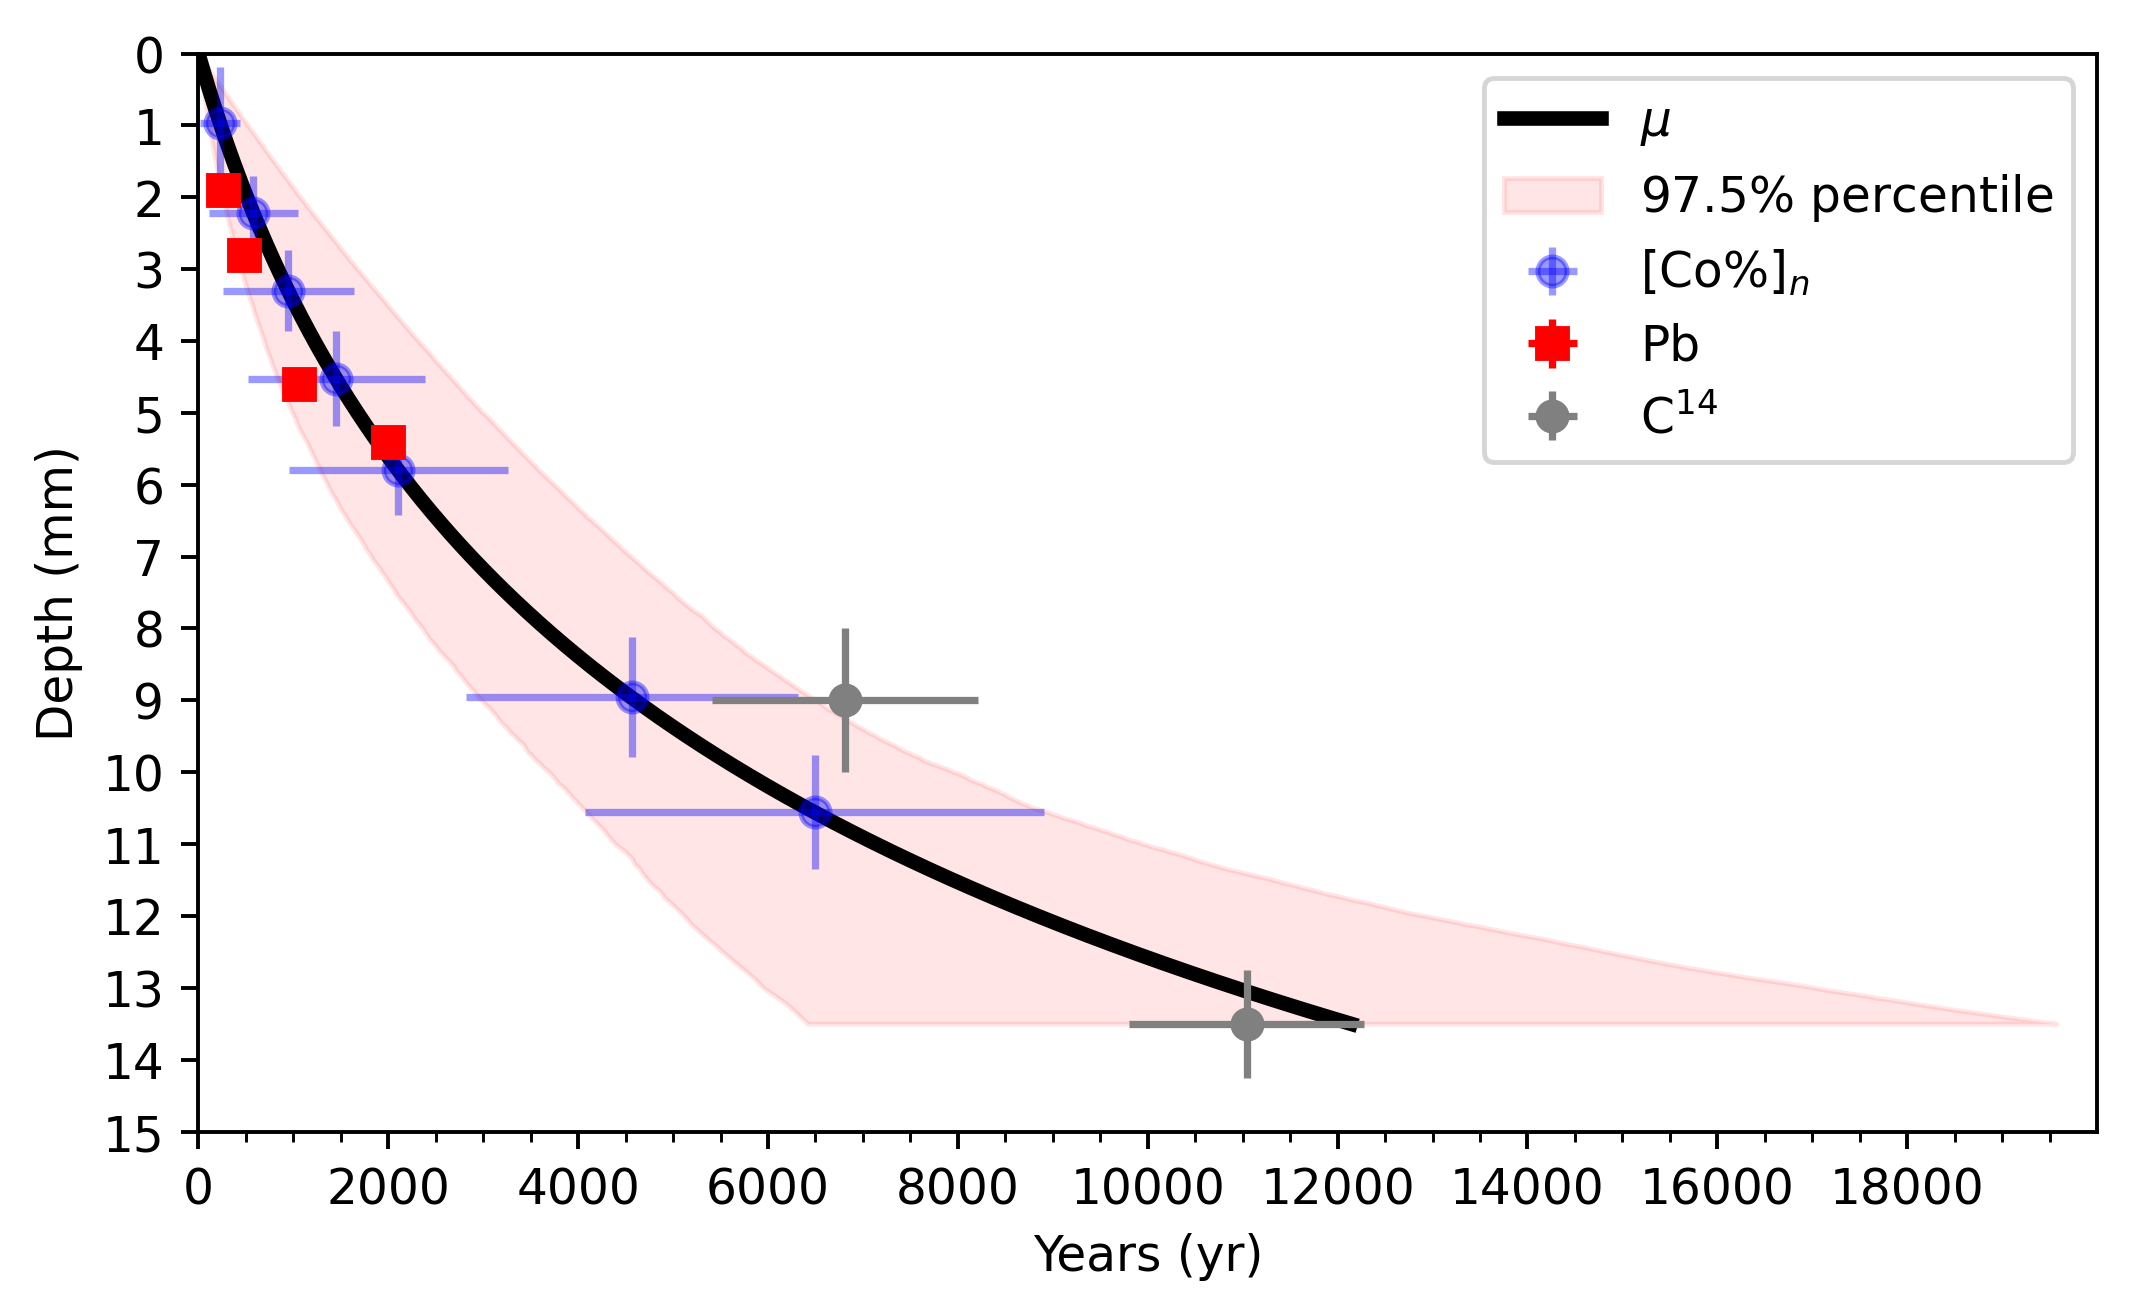

In [118]:



fig, ax = plt.subplots(1,1,figsize=(7,4), dpi= 350)

xx = np.arange(0, np.max(datas["Ages_d"]),1e-3)
xx_scaled = np.linspace(0, np.max(dataDict["Ages_d"]), len(xx))*1e3
yy = (a/(b*pow(alpha,b)*beta)*(1-np.exp(-b*xx*beta)))*1e4

x_val  = []
y_val  = []

for x_probe in np.mean(d_Co, axis=0)*1e-1:
    idx = np.argmin(np.abs(x_probe-xx))
    x_val.append(xx_scaled[idx])
    y_val.append(yy[:,idx])
    print(idx)
    
x_val = np.array(x_val)
y_val = np.array(y_val)

means = np.mean(yy, axis = 0)
stds = np.std(yy, axis = 0)
p95s = np.percentile(yy, 97.5, axis = 0)
p5s = np.percentile(yy, 2.5, axis = 0)


ax.plot(means, xx_scaled,"black",linewidth=3,label=r'$\mu$')
ax.fill_betweenx(xx_scaled, p5s,p95s, color = "red", alpha= 0.1,label=r'97.5$\%$ percentile')

#ax.plot(p95s, xx_scaled,'--b',alpha=0.8,label='95$\%$ percentile')
#ax.plot(p5s, xx_scaled,'--b',alpha=0.8)
# ax.scatter(dataDict["Ages"], np.array(draws.filter(regex='d_Ages_mu').mean(axis=0).values)*1e1,color = "black",marker='v',s=60, label = "Corrected depth")
#ax.scatter(y_val[0,::25], np.repeat(x_val[0],y_val[:,::25].shape[1]), color = "blue", alpha = 0.4, s=5, label = r"[Co$\%$] posterior draws")
#for i in range(1,len(x_val)):
#    ax.scatter(y_val[i,::25], np.repeat(x_val[i],y_val[:,::25].shape[1]), color = "blue", alpha = 0.4, s=5) 
#ax[2].scatter(dataDict["Ages"][:n_db], dataDict["Ages_d"][:n_db], color = "black", label = "Data")
#ax[2].scatter(dataDict["Ages"][n_db:], dataDict["Ages_d"][n_db:], color = "black", label = "Data")

p95s = np.percentile(y_val, 95, axis = 1)
p5s = np.percentile(y_val, 5, axis = 1)

Age_Co_mean = np.mean(y_val, axis = 1)
Age_Co_std = np.std(y_val, axis = 1)

ax.errorbar(Age_Co_mean, d_Co_mean, yerr = 2*d_Co_std, xerr=2*Age_Co_std, alpha = 0.4,ecolor = "blue", marker='o', mfc='blue', mec='blue',fmt='o',label=r'[Co$\%$]$_n$')

ax.errorbar(dataDict["Ages"][:n_db], dataDict["Ages_d"][:n_db]*1e3, yerr = dataDict["Ages_d_error"][:n_db]*1e3, xerr=dataDict["Ages_error"][:n_db],alpha = 1, ecolor = "red",marker='s', mfc='red', mec='red',fmt='o',label='Pb')
ax.errorbar(dataDict["Ages"][n_db:], dataDict["Ages_d"][n_db:]*1e3, yerr = dataDict["Ages_d_error"][n_db:]*1e3, xerr=dataDict["Ages_error"][n_db:],alpha = 1, ecolor = "grey", marker='o', mfc='grey', mec='grey',fmt='o',label=r'C$^{\text{14}}$')

# means = np.mean(y_val, axis = 1)
# stds = np.std(y_val, axis = 1)

# ax.errorbar(x_val, dataDict["Ages_d"][n_db:]*1e3, yerr = dataDict["Ages_d_error"][n_db:]*1e3, xerr=dataDict["Ages_error"][n_db:],alpha = 1, ecolor = "grey", marker='o', mfc='grey', mec='grey',fmt='o',label=r'C$^{\text{14}}$')



ax.set_ylim(0,14)
ax.set_xlim(0,20000)

ax.invert_yaxis()
ax.set_ylabel(r"Depth (mm)")
ax.set_xlabel(r"Years (yr)")
ax.legend()

# Set major ticks for x axis
major_yticks = np.arange(0, 16, 1)
# Set major ticks for y axis
major_xticks = np.arange(0, 20000, 2000)
# I want minor ticks for x axis
minor_yticks =  np.arange(1, 16, 2)
# I want minor ticks for y axis
minor_xticks = np.arange(0, 20000, 500)


# Specify tick label size
#ax.tick_params(axis = 'both', which = 'major', labelsize = 6)
#ax.tick_params(axis = 'both', which = 'minor', labelsize = 0)
## Supress minor tick labels
ax.set_xticks(major_xticks)
ax.set_xticks(minor_xticks, minor = True)
ax.set_yticks(major_yticks)
#ax.set_yticks(minor_yticks, minor = True)


plt.savefig('Age_depth_draws.svg', format='svg', bbox_inches='tight')
plt.show()
plt.close()


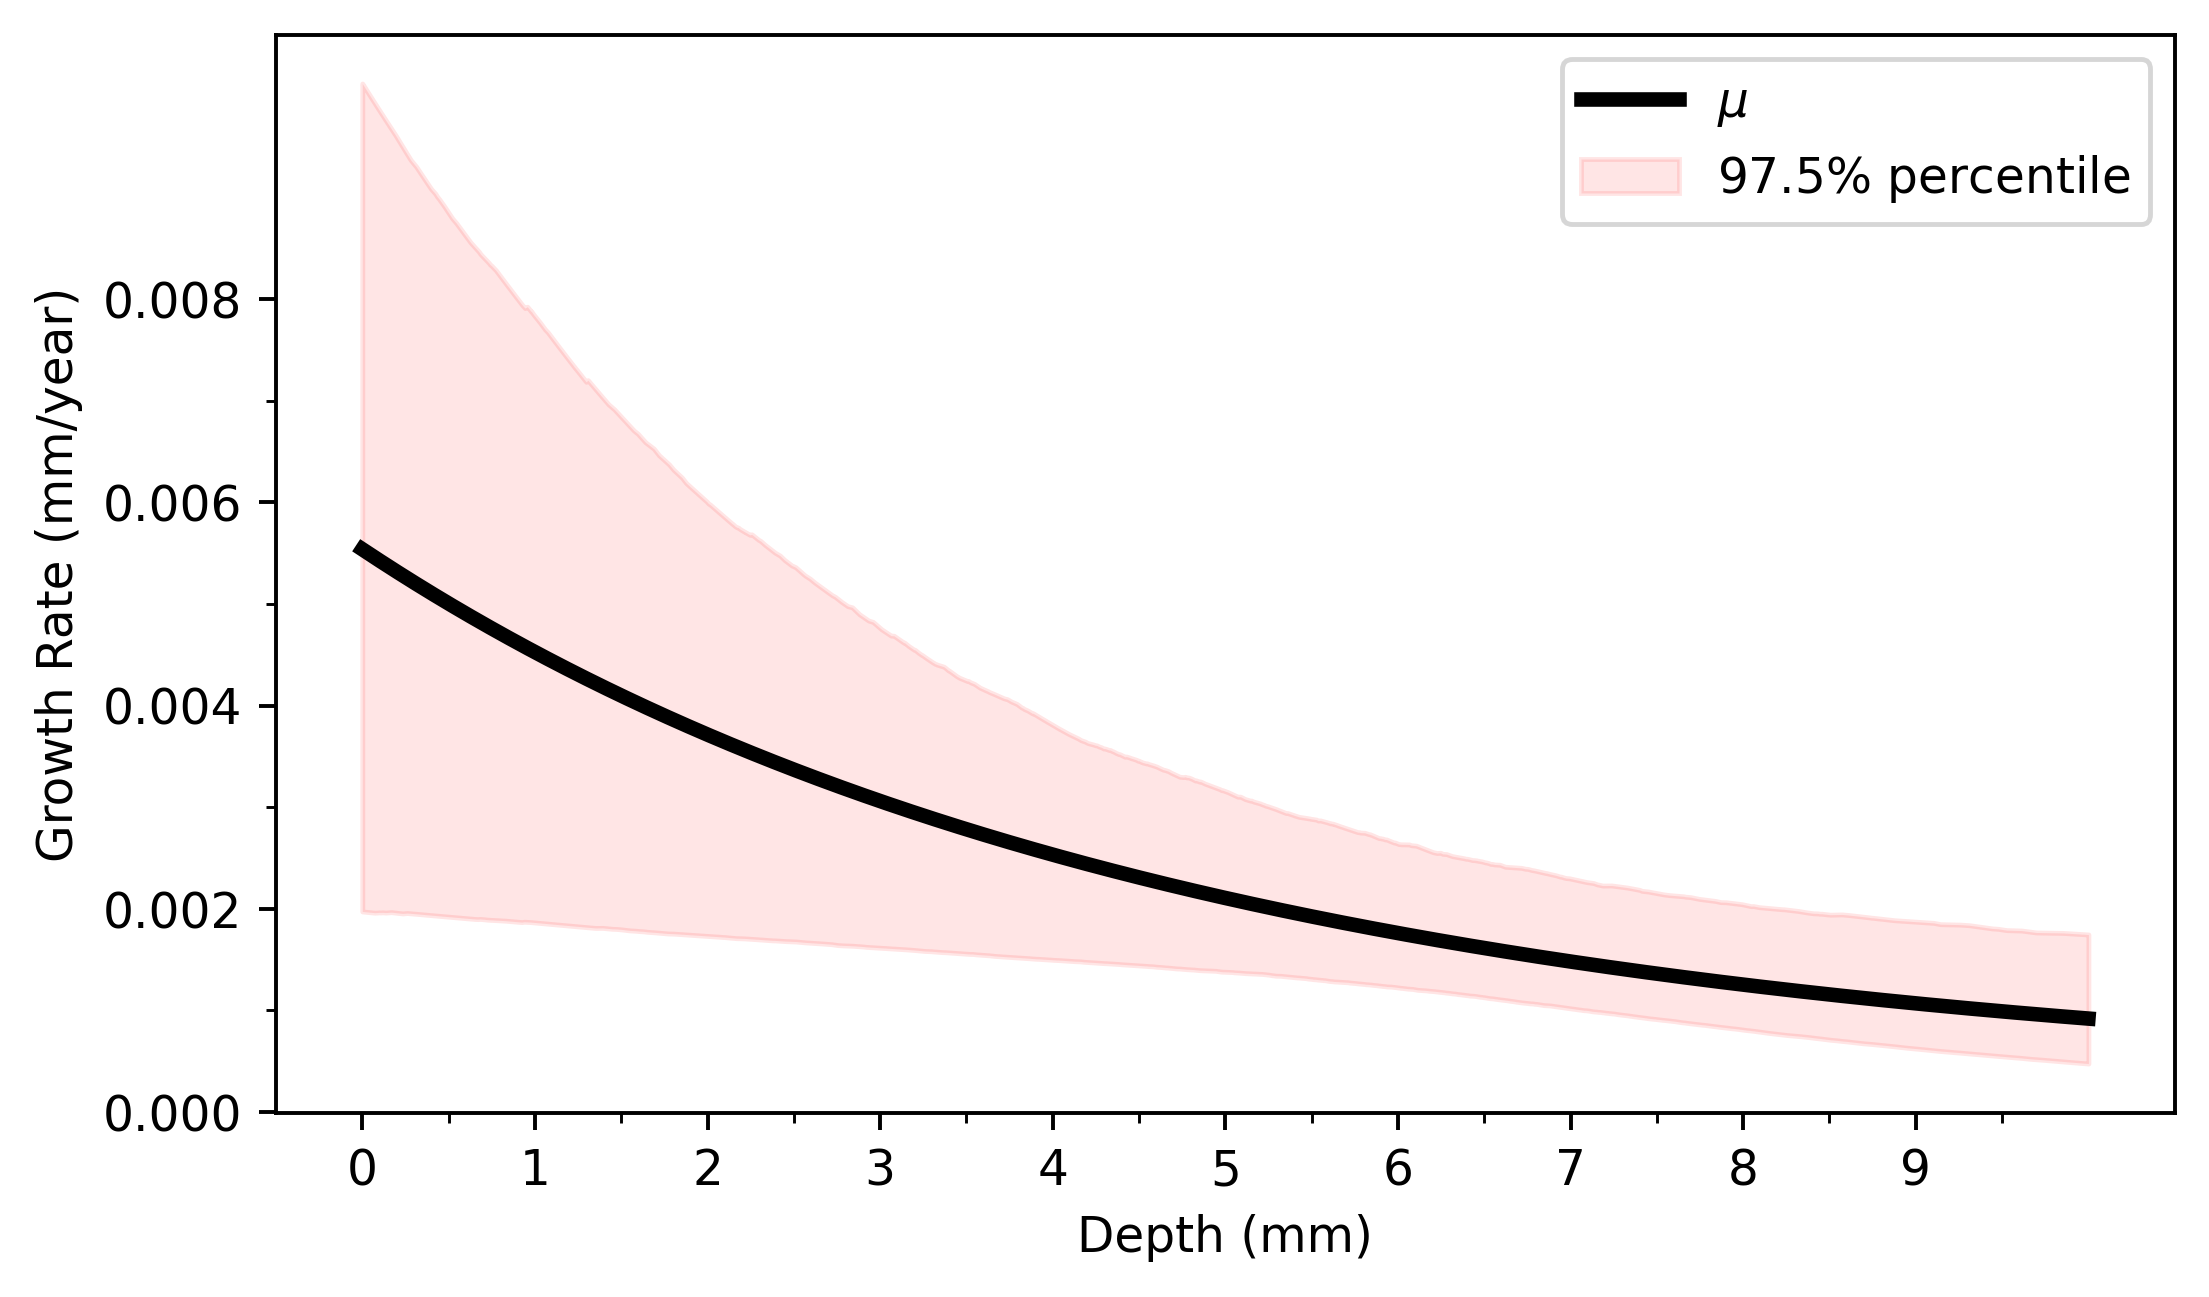

In [119]:



fig, ax = plt.subplots(1,1,figsize=(7,4), dpi= 350) #, dpi= 350

xx = df_results["depth"].values*1e-1
xx_scaled = df_results["depth"].values

yy = 1/((a/(alpha*np.exp(beta*xx))**b)*1e4*1e-1)

means = np.mean(yy, axis = 0)
#stds = np.std(yy, axis = 0)
p95s = np.percentile(yy, 97.5, axis = 0)
p5s = np.percentile(yy, 2.5, axis = 0)


ax.plot(xx_scaled, means,"black",linewidth=3,label=r'$\mu$')
ax.fill_between(xx_scaled, p5s, p95s, color = "red", alpha= 0.1,label=r'97.5$\%$ percentile')

#ax.plot( xx_scaled,p95s,'--b',alpha=0.8,label='97.5$\%$ percentile')
#ax.plot(xx_scaled,p5s, '--b',alpha=0.8)
#xx_scaled = df_results["depth"].values*100 #Fit
#ax.st_ylim(0,14)
#ax.set_xlim(0,20000)
#ax.invert_yaxis()

ax.set_xlabel(r"Depth (mm)")
ax.set_ylabel(r"Growth Rate (mm/year)")


ax.legend()

# Set major ticks for x axis
major_yticks = np.arange(0, 10, 1)
# Set major ticks for y axis
major_xticks = np.arange(0, 0.009, 0.002)
# I want minor ticks for x axis
minor_yticks =  np.arange(0.5, 10, 1)
# I want minor ticks for y axis
minor_xticks = np.arange(0.001, 0.009, 0.002)


# Specify tick label size
#ax.tick_params(axis = 'both', which = 'major', labelsize = 6)
#ax.tick_params(axis = 'both', which = 'minor', labelsize = 0)
## Supress minor tick labels
ax.set_xticks(major_yticks)
ax.set_xticks(minor_yticks, minor = True)
ax.set_yticks(major_xticks)
ax.set_yticks(minor_xticks, minor = True)


plt.savefig('GR_depth.svg', format='svg', bbox_inches='tight')
plt.show()
plt.close()


In [36]:
def elpd(dataD, phase, num):

    datas = {}


    datas["Ages"] = (dataD["Ages"]*1e-4).tolist()
    datas["Ages_error"] = np.abs(dataD["Ages_error"]*1e-4).tolist()

    datas["Co_"] = (dataD["Co_"]).tolist() 
    datas["Co_e"] =  np.abs((dataD["Co_sigma"])).tolist()

    datas["Fe_"] = (dataD["Fe_"]).tolist() 
    datas["Fe_e"] =  np.abs((dataD["Fe_sigma"])).tolist()

    datas["Mn_"] = (dataD["Mn_"]).tolist() 
    datas["Mn_e"] =  np.abs((dataD["Mn_sigma"])).tolist()


    datas["Co_d"] = (dataD["Co_d"]*100).tolist()
    datas["Co_d_error"] = np.abs(dataD["Co_d_error"]*100).tolist()

    datas["Ages_d"] = (dataD["Ages_d"]*100).tolist()
    datas["Ages_d_error"] = np.abs(dataD["Ages_d_error"]*100).tolist()

    datas["n_i"] = len(dataD["Co"])
    datas["n_j"] = len(dataD["Ages"])


    if phase == "Age":
        datas["Ages"].pop(num)
        datas["Ages_d"].pop(num)
        datas["Ages_error"].pop(num)
        datas["Ages_d_error"].pop(num)
        datas["n_j"] = datas["n_j"]-1 

    else:
        datas["Co_"].pop(num)
        datas["Co_e"].pop(num)
        datas["Fe_"].pop(num)
        datas["Fe_e"].pop(num)
        datas["Mn_"].pop(num)
        datas["Mn_e"].pop(num)

        datas["Co_d"].pop(num)
        datas["Co_d_error"].pop(num)
        datas["n_i"] = datas["n_i"]-1 

    
    datas['n_Co_n_indices'] = (np.arange(datas['n_i'])+1).tolist()
    datas['n_Co_indices'] = (np.arange(datas['n_i'])+datas['n_i']+1).tolist()
    datas['n_j_indices'] = (np.arange(datas['n_j'])+int(2*datas['n_i'])+1).tolist()
        
    with open('data.json','w') as f:
        json.dump(datas,f)

    model = CmdStanModel(stan_file='C:/Users/Arttu/Desktop/Codes/TeachingSolution/AgeModel/minSol_mod_exp.stan')
    fit = model.sample(data='C:/Users/Arttu/Desktop/Codes/TeachingSolution/AgeModel/data.json') #, adapt_delta=0.9999,max_treedepth=20, adapt_delta=0.9999,max_treedepth=20) #show_console=True
    logs = fit.draws_pd().filter(regex=r'log_lik*').values
    print("Dropped: ", num, " in ", phase)
    azOut = az.from_cmdstanpy(posterior=fit,
                                posterior_predictive='y_hat',
                                log_likelihood='log_lik',
                                observed_data={'y': datas["Ages"] })
    print(az.loo(azOut))
    
    return logs

all_logs = []

for i in range(datas["n_j"]):
    logs_ = elpd(dataDict, "Age", i)
    all_logs.append(logs_)

for i in range(datas["n_i"]):
    logs_ = elpd(dataDict, "Co", i)
    all_logs.append(logs_)

loggs = np.hstack(all_logs)
elpds = np.log(np.mean(np.exp(loggs),axis=0))



09:18:33 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

09:18:49 - cmdstanpy - INFO - CmdStan done processing.
09:18:49 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Location parameter[2] is inf, but must be finite! (in 'minSol_mod_exp.stan', line 132, column 3 to column 49)
	Exception: normal_lpdf: Location parameter[2] is inf, but must be finite! (in 'minSol_mod_exp.stan', line 132, column 3 to column 49)
	Exception: normal_lpdf: Location parameter[2] is inf, but must be finite! (in 'minSol_mod_exp.stan', line 110, column 3 to column 30)
	Exception: normal_lpdf: Location parameter[4] is inf, but must be finite! (in 'minSol_mod_exp.stan', line 110, column 3 to column 30)
Exception: normal_lpdf: Location parameter[1] is inf, but must be finite! (in 'minSol_mod_exp.stan', line 110, column 3 to column 30)
	Exception: normal_lpdf: Location parameter[2] is inf, but must be finite! (in 'minSol_mod_exp.stan', line 110, column 3 to column 30)
Exception: student_t_lpdf: Location parameter[1] is nan, but must be fi

09:18:49 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 3 had 1 divergent transitions (0.1%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.


Dropped:  0  in  Age
Computed from 4000 posterior samples and 26 observations log-likelihood matrix.

         Estimate       SE
elpd_loo    47.87    15.47
p_loo       23.17        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.70]   (good)        3   11.5%
   (0.70, 1]   (bad)        19   73.1%
   (1, Inf)   (very bad)    4   15.4%



c:\Users\Arttu\Anaconda3\envs\stan\Lib\site-packages\arviz\stats\stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
09:18:50 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

09:19:28 - cmdstanpy - INFO - CmdStan done processing.
09:19:28 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Location parameter[3] is inf, but must be finite! (in 'minSol_mod_exp.stan', line 132, column 3 to column 49)
	Exception: normal_lpdf: Location parameter[3] is inf, but must be finite! (in 'minSol_mod_exp.stan', line 132, column 3 to column 49)
	Exception: normal_lpdf: Location parameter[2] is inf, but must be finite! (in 'minSol_mod_exp.stan', line 110, column 3 to column 30)
	Exception: normal_lpdf: Location parameter[2] is inf, but must be finite! (in 'minSol_mod_exp.stan', line 110, column 3 to column 30)
Exception: normal_lpdf: Location parameter[5] is inf, but must be finite! (in 'minSol_mod_exp.stan', line 111, column 3 to column 30)
	Exception: normal_lpdf: Location parameter[5] is inf, but must be finite! (in 'minSol_mod_exp.stan', line 111, column 3 to column 30)
	Exception: normal_lpdf: Location parameter[1] is inf, but must be fini


Dropped:  1  in  Age


c:\Users\Arttu\Anaconda3\envs\stan\Lib\site-packages\arviz\stats\stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


Computed from 4000 posterior samples and 26 observations log-likelihood matrix.

         Estimate       SE
elpd_loo    50.53    15.90
p_loo       20.56        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.70]   (good)        6   23.1%
   (0.70, 1]   (bad)        13   50.0%
   (1, Inf)   (very bad)    7   26.9%



09:19:29 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

09:19:46 - cmdstanpy - INFO - CmdStan done processing.
09:19:46 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Location parameter[3] is inf, but must be finite! (in 'minSol_mod_exp.stan', line 132, column 3 to column 49)
	Exception: normal_lpdf: Location parameter[3] is inf, but must be finite! (in 'minSol_mod_exp.stan', line 132, column 3 to column 49)
	Exception: student_t_lpdf: Location parameter[3] is -inf, but must be finite! (in 'minSol_mod_exp.stan', line 140, column 3 to column 52)
	Exception: student_t_lpdf: Location parameter[3] is -inf, but must be finite! (in 'minSol_mod_exp.stan', line 140, column 3 to column 52)
	Exception: normal_lpdf: Location parameter[1] is inf, but must be finite! (in 'minSol_mod_exp.stan', line 110, column 3 to column 30)
	Exception: normal_lpdf: Location parameter[2] is inf, but must be finite! (in 'minSol_mod_exp.stan', line 110, column 3 to column 30)
	Exception: student_t_lpdf: Location parameter[3] is -inf, but


Dropped:  2  in  Age
Computed from 4000 posterior samples and 26 observations log-likelihood matrix.

         Estimate       SE
elpd_loo    48.43    15.35
p_loo       22.40        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.70]   (good)        3   11.5%
   (0.70, 1]   (bad)        16   61.5%
   (1, Inf)   (very bad)    7   26.9%



c:\Users\Arttu\Anaconda3\envs\stan\Lib\site-packages\arviz\stats\stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
09:19:47 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

09:20:04 - cmdstanpy - INFO - CmdStan done processing.
09:20:04 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Location parameter[5] is inf, but must be finite! (in 'minSol_mod_exp.stan', line 111, column 3 to column 30)
	Exception: normal_lpdf: Location parameter[5] is inf, but must be finite! (in 'minSol_mod_exp.stan', line 111, column 3 to column 30)
	Exception: student_t_lpdf: Location parameter[3] is -inf, but must be finite! (in 'minSol_mod_exp.stan', line 140, column 3 to column 52)
	Exception: normal_lpdf: Location parameter[1] is inf, but must be finite! (in 'minSol_mod_exp.stan', line 110, column 3 to column 30)
	Exception: normal_lpdf: Location parameter[4] is inf, but must be finite! (in 'minSol_mod_exp.stan', line 110, column 3 to column 30)
Exception: normal_lpdf: Location parameter[1] is inf, but must be finite! (in 'minSol_mod_exp.stan', line 110, column 3 to column 30)
	Exception: normal_lpdf: Location parameter[3] is inf, but must be 


Dropped:  3  in  Age


c:\Users\Arttu\Anaconda3\envs\stan\Lib\site-packages\arviz\stats\stats.py:1043: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
c:\Users\Arttu\Anaconda3\envs\stan\Lib\site-packages\numpy\_core\_methods.py:53: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
c:\Users\Arttu\Anaconda3\envs\stan\Lib\site-packages\arviz\stats\stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


Computed from 4000 posterior samples and 26 observations log-likelihood matrix.

         Estimate       SE
elpd_loo    50.20    15.18
p_loo       21.53        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.70]   (good)        3   11.5%
   (0.70, 1]   (bad)        19   73.1%
   (1, Inf)   (very bad)    4   15.4%



09:20:05 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

09:20:21 - cmdstanpy - INFO - CmdStan done processing.
09:20:21 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Location parameter[5] is inf, but must be finite! (in 'minSol_mod_exp.stan', line 111, column 3 to column 30)
	Exception: normal_lpdf: Location parameter[5] is inf, but must be finite! (in 'minSol_mod_exp.stan', line 111, column 3 to column 30)
	Exception: student_t_lpdf: Location parameter[2] is inf, but must be finite! (in 'minSol_mod_exp.stan', line 140, column 3 to column 52)
	Exception: student_t_lpdf: Location parameter[2] is inf, but must be finite! (in 'minSol_mod_exp.stan', line 140, column 3 to column 52)
	Exception: student_t_lpdf: Location parameter[3] is inf, but must be finite! (in 'minSol_mod_exp.stan', line 140, column 3 to column 52)
	Exception: normal_lpdf: Location parameter[1] is inf, but must be finite! (in 'minSol_mod_exp.stan', line 110, column 3 to column 30)
	Exception: normal_lpdf: Location parameter[3] is inf, but mu


Dropped:  4  in  Age
Computed from 4000 posterior samples and 26 observations log-likelihood matrix.

         Estimate       SE
elpd_loo    51.40    15.61
p_loo       23.94        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.70]   (good)        6   23.1%
   (0.70, 1]   (bad)        15   57.7%
   (1, Inf)   (very bad)    5   19.2%



c:\Users\Arttu\Anaconda3\envs\stan\Lib\site-packages\arviz\stats\stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
09:20:22 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

09:20:45 - cmdstanpy - INFO - CmdStan done processing.
09:20:45 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Location parameter[3] is inf, but must be finite! (in 'minSol_mod_exp.stan', line 132, column 3 to column 49)
	Exception: normal_lpdf: Location parameter[3] is inf, but must be finite! (in 'minSol_mod_exp.stan', line 132, column 3 to column 49)
	Exception: normal_lpdf: Location parameter[2] is inf, but must be finite! (in 'minSol_mod_exp.stan', line 110, column 3 to column 30)
	Exception: normal_lpdf: Location parameter[4] is inf, but must be finite! (in 'minSol_mod_exp.stan', line 110, column 3 to column 30)
	Exception: student_t_lpdf: Location parameter[3] is inf, but must be finite! (in 'minSol_mod_exp.stan', line 140, column 3 to column 52)
Exception: normal_lpdf: Location parameter[3] is inf, but must be finite! (in 'minSol_mod_exp.stan', line 132, column 3 to column 49)
	Exception: normal_lpdf: Location parameter[3] is inf, but must be f


Dropped:  5  in  Age


c:\Users\Arttu\Anaconda3\envs\stan\Lib\site-packages\arviz\stats\stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


Computed from 4000 posterior samples and 26 observations log-likelihood matrix.

         Estimate       SE
elpd_loo    49.94    15.11
p_loo       22.60        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.70]   (good)        3   11.5%
   (0.70, 1]   (bad)        15   57.7%
   (1, Inf)   (very bad)    8   30.8%



09:20:46 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

09:20:57 - cmdstanpy - INFO - CmdStan done processing.
09:20:57 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Location parameter[4] is inf, but must be finite! (in 'minSol_mod_exp.stan', line 111, column 3 to column 30)
	Exception: normal_lpdf: Location parameter[4] is inf, but must be finite! (in 'minSol_mod_exp.stan', line 111, column 3 to column 30)
	Exception: normal_lpdf: Location parameter[1] is inf, but must be finite! (in 'minSol_mod_exp.stan', line 110, column 3 to column 30)
	Exception: normal_lpdf: Location parameter[6] is inf, but must be finite! (in 'minSol_mod_exp.stan', line 110, column 3 to column 30)
Exception: normal_lpdf: Location parameter[3] is inf, but must be finite! (in 'minSol_mod_exp.stan', line 132, column 3 to column 49)
	Exception: normal_lpdf: Location parameter[3] is inf, but must be finite! (in 'minSol_mod_exp.stan', line 132, column 3 to column 49)
	Exception: student_t_lpdf: Location parameter[3] is -inf, but must be 


Dropped:  0  in  Co
Computed from 4000 posterior samples and 24 observations log-likelihood matrix.

         Estimate       SE
elpd_loo    43.29    13.67
p_loo       21.10        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.70]   (good)        3   12.5%
   (0.70, 1]   (bad)        17   70.8%
   (1, Inf)   (very bad)    4   16.7%



c:\Users\Arttu\Anaconda3\envs\stan\Lib\site-packages\arviz\stats\stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
09:20:57 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

09:21:10 - cmdstanpy - INFO - CmdStan done processing.
09:21:10 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Location parameter[3] is inf, but must be finite! (in 'minSol_mod_exp.stan', line 132, column 3 to column 49)
	Exception: normal_lpdf: Location parameter[3] is inf, but must be finite! (in 'minSol_mod_exp.stan', line 132, column 3 to column 49)
	Exception: student_t_lpdf: Location parameter[3] is -inf, but must be finite! (in 'minSol_mod_exp.stan', line 140, column 3 to column 52)
	Exception: student_t_lpdf: Location parameter[3] is -inf, but must be finite! (in 'minSol_mod_exp.stan', line 140, column 3 to column 52)
	Exception: normal_lpdf: Location parameter[1] is inf, but must be finite! (in 'minSol_mod_exp.stan', line 110, column 3 to column 30)
	Exception: normal_lpdf: Location parameter[2] is inf, but must be finite! (in 'minSol_mod_exp.stan', line 110, column 3 to column 30)
	Exception: student_t_lpdf: Location parameter[3] is -inf, but


Dropped:  1  in  Co


c:\Users\Arttu\Anaconda3\envs\stan\Lib\site-packages\arviz\stats\stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


Computed from 4000 posterior samples and 24 observations log-likelihood matrix.

         Estimate       SE
elpd_loo    46.68    14.02
p_loo       19.42        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.70]   (good)        4   16.7%
   (0.70, 1]   (bad)        18   75.0%
   (1, Inf)   (very bad)    2    8.3%



09:21:11 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

09:21:25 - cmdstanpy - INFO - CmdStan done processing.
09:21:25 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Location parameter[4] is inf, but must be finite! (in 'minSol_mod_exp.stan', line 111, column 3 to column 30)
	Exception: normal_lpdf: Location parameter[4] is inf, but must be finite! (in 'minSol_mod_exp.stan', line 111, column 3 to column 30)
	Exception: normal_lpdf: Location parameter[2] is inf, but must be finite! (in 'minSol_mod_exp.stan', line 110, column 3 to column 30)
	Exception: normal_lpdf: Location parameter[2] is inf, but must be finite! (in 'minSol_mod_exp.stan', line 110, column 3 to column 30)
Exception: normal_lpdf: Location parameter[4] is inf, but must be finite! (in 'minSol_mod_exp.stan', line 132, column 3 to column 49)
	Exception: normal_lpdf: Location parameter[4] is inf, but must be finite! (in 'minSol_mod_exp.stan', line 132, column 3 to column 49)
	Exception: student_t_lpdf: Location parameter[4] is inf, but must be f


Dropped:  2  in  Co


c:\Users\Arttu\Anaconda3\envs\stan\Lib\site-packages\arviz\stats\stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


Computed from 4000 posterior samples and 24 observations log-likelihood matrix.

         Estimate       SE
elpd_loo    45.31    14.10
p_loo       21.27        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.70]   (good)        6   25.0%
   (0.70, 1]   (bad)        15   62.5%
   (1, Inf)   (very bad)    3   12.5%



09:21:26 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

09:21:37 - cmdstanpy - INFO - CmdStan done processing.
09:21:37 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Location parameter[3] is inf, but must be finite! (in 'minSol_mod_exp.stan', line 132, column 3 to column 49)
	Exception: normal_lpdf: Location parameter[3] is inf, but must be finite! (in 'minSol_mod_exp.stan', line 132, column 3 to column 49)
	Exception: normal_lpdf: Location parameter[1] is inf, but must be finite! (in 'minSol_mod_exp.stan', line 110, column 3 to column 30)
	Exception: normal_lpdf: Location parameter[2] is inf, but must be finite! (in 'minSol_mod_exp.stan', line 110, column 3 to column 30)
Exception: normal_lpdf: Location parameter[4] is inf, but must be finite! (in 'minSol_mod_exp.stan', line 111, column 3 to column 30)
	Exception: normal_lpdf: Location parameter[4] is inf, but must be finite! (in 'minSol_mod_exp.stan', line 111, column 3 to column 30)
	Exception: normal_lpdf: Location parameter[1] is inf, but must be fini


Dropped:  3  in  Co


c:\Users\Arttu\Anaconda3\envs\stan\Lib\site-packages\arviz\stats\stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


Computed from 4000 posterior samples and 24 observations log-likelihood matrix.

         Estimate       SE
elpd_loo    45.59    14.02
p_loo       19.63        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.70]   (good)        9   37.5%
   (0.70, 1]   (bad)        10   41.7%
   (1, Inf)   (very bad)    5   20.8%



09:21:38 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

09:21:49 - cmdstanpy - INFO - CmdStan done processing.
09:21:49 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Location parameter[3] is inf, but must be finite! (in 'minSol_mod_exp.stan', line 132, column 3 to column 49)
	Exception: normal_lpdf: Location parameter[3] is inf, but must be finite! (in 'minSol_mod_exp.stan', line 132, column 3 to column 49)
	Exception: student_t_lpdf: Location parameter[3] is inf, but must be finite! (in 'minSol_mod_exp.stan', line 140, column 3 to column 52)
	Exception: normal_lpdf: Location parameter[1] is inf, but must be finite! (in 'minSol_mod_exp.stan', line 110, column 3 to column 30)
	Exception: normal_lpdf: Location parameter[3] is inf, but must be finite! (in 'minSol_mod_exp.stan', line 110, column 3 to column 30)
Exception: normal_lpdf: Location parameter[4] is inf, but must be finite! (in 'minSol_mod_exp.stan', line 132, column 3 to column 49)
	Exception: normal_lpdf: Location parameter[4] is inf, but must be f


Dropped:  4  in  Co


c:\Users\Arttu\Anaconda3\envs\stan\Lib\site-packages\arviz\stats\stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


Computed from 4000 posterior samples and 24 observations log-likelihood matrix.

         Estimate       SE
elpd_loo    46.66    14.50
p_loo       18.71        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.70]   (good)        8   33.3%
   (0.70, 1]   (bad)        14   58.3%
   (1, Inf)   (very bad)    2    8.3%



09:21:50 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

09:22:05 - cmdstanpy - INFO - CmdStan done processing.
09:22:05 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Location parameter[1] is inf, but must be finite! (in 'minSol_mod_exp.stan', line 110, column 3 to column 30)
	Exception: normal_lpdf: Location parameter[2] is inf, but must be finite! (in 'minSol_mod_exp.stan', line 110, column 3 to column 30)
Exception: normal_lpdf: Location parameter[5] is inf, but must be finite! (in 'minSol_mod_exp.stan', line 111, column 3 to column 30)
	Exception: normal_lpdf: Location parameter[5] is inf, but must be finite! (in 'minSol_mod_exp.stan', line 111, column 3 to column 30)
	Exception: normal_lpdf: Location parameter[1] is inf, but must be finite! (in 'minSol_mod_exp.stan', line 110, column 3 to column 30)
	Exception: normal_lpdf: Location parameter[6] is inf, but must be finite! (in 'minSol_mod_exp.stan', line 110, column 3 to column 30)
Exception: normal_lpdf: Location parameter[1] is inf, but must be finit


Dropped:  5  in  Co
Computed from 4000 posterior samples and 24 observations log-likelihood matrix.

         Estimate       SE
elpd_loo    45.82    14.39
p_loo       21.80        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.70]   (good)        5   20.8%
   (0.70, 1]   (bad)        16   66.7%
   (1, Inf)   (very bad)    3   12.5%



c:\Users\Arttu\Anaconda3\envs\stan\Lib\site-packages\arviz\stats\stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
09:22:06 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

09:22:21 - cmdstanpy - INFO - CmdStan done processing.
09:22:21 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Location parameter[3] is inf, but must be finite! (in 'minSol_mod_exp.stan', line 132, column 3 to column 49)
	Exception: normal_lpdf: Location parameter[3] is inf, but must be finite! (in 'minSol_mod_exp.stan', line 132, column 3 to column 49)
	Exception: normal_lpdf: Location parameter[2] is inf, but must be finite! (in 'minSol_mod_exp.stan', line 110, column 3 to column 30)
	Exception: normal_lpdf: Location parameter[2] is inf, but must be finite! (in 'minSol_mod_exp.stan', line 110, column 3 to column 30)
Exception: normal_lpdf: Location parameter[4] is inf, but must be finite! (in 'minSol_mod_exp.stan', line 132, column 3 to column 49)
	Exception: normal_lpdf: Location parameter[4] is inf, but must be finite! (in 'minSol_mod_exp.stan', line 132, column 3 to column 49)
	Exception: normal_lpdf: Location parameter[2] is inf, but must be fini


Dropped:  6  in  Co
Computed from 4000 posterior samples and 24 observations log-likelihood matrix.

         Estimate       SE
elpd_loo    40.54    13.44
p_loo       21.64        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.70]   (good)        4   16.7%
   (0.70, 1]   (bad)        17   70.8%
   (1, Inf)   (very bad)    3   12.5%



c:\Users\Arttu\Anaconda3\envs\stan\Lib\site-packages\arviz\stats\stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


sum:  893.4290381477402 
 se:  52.166105232956845


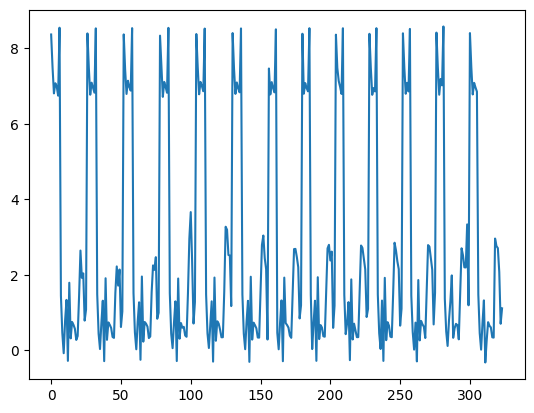

In [23]:
print("sum: ", np.sum(elpds), "\n se: ", np.sqrt(len(elpds))*np.std(elpds))
plt.plot(elpds)

In [135]:
root = "./tools/Wasiljeff et al trace element depth values for GR.xlsx" # change this to ~/Agemodeldatamgbc202141.xlsx
df_results = pd.read_excel(root)
df_results.columns = ["depth", "GR"]
df_results["depth"] = df_results["depth"]*1e-3

root = "./tools/Wasiljeff et al in situ Fe Mn Pb density.xlsx" # change this to ~/Agemodeldatamgbc202141.xlsx
df_sup = pd.read_excel(root, skiprows = np.arange(0,2))
df_sup["Thickness"] = df_sup["Thickness"]*1e-3
df_sup = df_sup[df_sup.columns[:7]]
df_sup = df_sup.dropna()

In [ ]:
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import GridSearchCV

kr = GridSearchCV(
    KernelRidge(kernel="rbf", gamma=0.1),
    param_grid={"alpha": [1e0, 0.1, 1e-2, 1e-3], "gamma": np.logspace(-2, 2, 5)},
)

kr.fit(df_sup["Thickness"].values.reshape(-1,1), df_sup["Mn "].values)

y_kr = kr.predict(df_sup["Thickness"].values.reshape(-1,1))

plt.plot(df_sup["Thickness"].values.reshape(-1,1),y_kr)

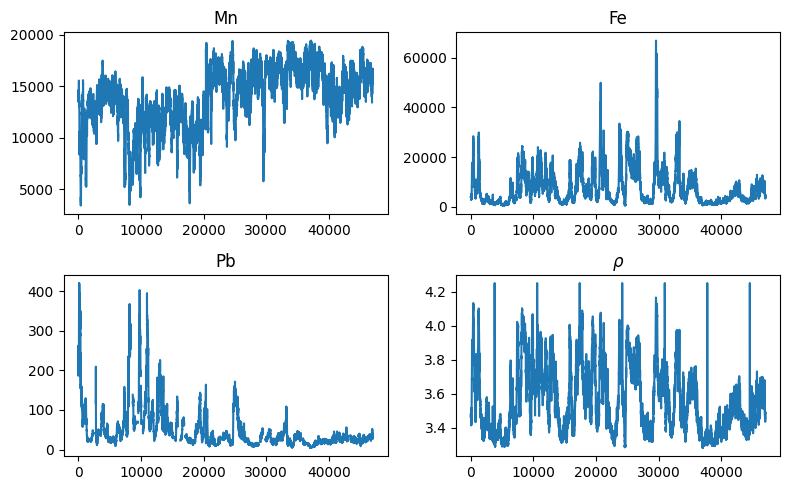

In [87]:
fig, ax = plt.subplots(2,2, figsize = (8,5))

ax[0,0].set_title("Mn")
ax[0,0].plot(df_sup["Mn "])
ax[0,1].set_title("Fe")
ax[0,1].plot(df_sup["Fe"])
ax[1,0].set_title("Pb")
ax[1,0].plot(df_sup["Pb"])
ax[1,1].set_title(r"$\rho$")
ax[1,1].plot(df_sup[df_sup.columns[7]])
fig.tight_layout()

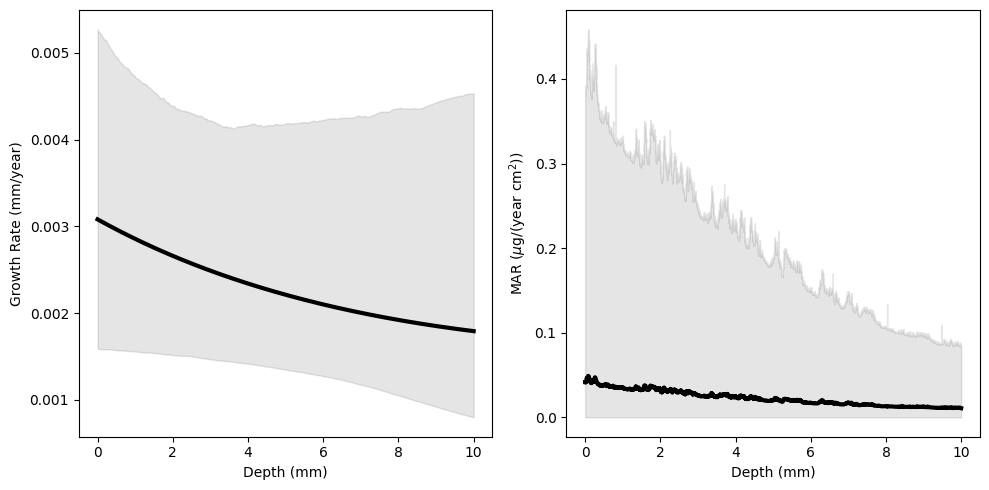

In [ ]:
rho_fe = 4.25 #g/cm3
rho_Mn = 3.26 #g/cm3
xx = df_results["depth"].values #m


xx_scaled = df_results["depth"].values*100 #Fit
yy = (a/(b*pow(alpha,b)*beta)*(1-np.exp(-b*xx_scaled*beta)))*1e4 #years
GR_yy = np.gradient(xx, axis = 0)/np.gradient(yy, axis = 1)*1e3 #m/years -> mm/years

DBD = df_sup[df_sup.columns[7]]*1e-3 #g/cm3 -> g/mm3
LSR = GR_yy #mm/years

C_x = alpha*np.exp(beta*xx_scaled)*1e-1 #fraction 1

MAR = np.zeros_like(LSR)

for i in range(4000):
    MAR[i,:] = C_x[i,:]/100*LSR[i,:]*DBD # %/100 * mm/year * g/mm3 = g/(year*mm2)


MAR = MAR*1e6*1e2


means_ = np.mean(GR_yy, axis = 0)
stds_ = np.std(GR_yy, axis = 0)
p95s_ = np.percentile(GR_yy, 95, axis = 0)
p5s_ = np.percentile(GR_yy, 5, axis = 0)

means = np.mean(MAR, axis = 0)
means = scipy.ndimage.gaussian_filter(means, 5)

stds = np.std(MAR, axis = 0)
p95s = np.percentile(MAR, 95, axis = 0)
p5s = np.percentile(MAR, 5, axis = 0)


fig, ax  = plt.subplots(1,2, figsize=(10,5))


ax[0].plot(xx*1e3,means_,"black",linewidth=3,label=r'$\mu$')
ax[0].fill_between(xx*1e3,p5s_,p95s_, color = "black", alpha= 0.1, label=r'$95\%$ percentile' )

ax[1].plot(xx*1e3,means,"black",linewidth=3,label=r'$\mu$')
ax[1].fill_between(xx*1e3,p5s,p95s, color = "black", alpha= 0.1, label=r'$95\%$ percentile' )

ax[0].set_xlabel("Depth (mm)")
ax[0].set_ylabel("Growth Rate (mm/year)")

ax[1].set_xlabel("Depth (mm)")
ax[1].set_ylabel(r"MAR ($\mu$g/(year cm$^2$))")

fig.tight_layout()
plt.show()

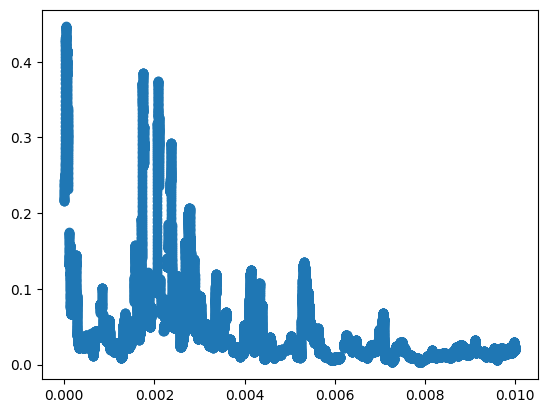

In [77]:
import scipy.ndimage


den_pb = df_sup["Pb"] #ug/g
rho_pb = df_sup[df_sup.columns[7]] #g/cm3

xx_scaled = df_results["depth"].values*100 #Fit
yy = (a/(b*pow(alpha,b)*beta)*(1-np.exp(-b*xx_scaled*beta)))*1e4 #years
s_delta_T  = np.gradient(xx*1e2, axis = 0)/np.gradient(yy, axis = 1) #cm/years

MAR = np.zeros_like(yy)
for i in range(4000):
    MAR[i,:] = den_pb * rho_pb * s_delta_T[i,:] # %/100 * mm/year * g/mm3 = g/(year*mm2)

MAR = np.mean(MAR, axis = 0)

plt.scatter(xx, scipy.ndimage.gaussian_filter(MAR,10))




In [52]:
df_mega = pd.DataFrame()

df_mega["depth (mm)"] = xx*1e3

df_mega["Co_n (1)"] = np.mean(C_x)
df_mega["Age (year)"] = np.mean(yy)
df_mega["growth Rate (mm/year)"] = np.mean(GR_yy)

df_mega["DBD (g/mm3)"] = np.mean(DBD)
df_mega["MAR (g/(year*mm2))"] = np.mean(MAR)

df_mega.to_csv("./tools/results_comp.csv", index = False)

